In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    compress_repeated_epochs,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.place_cells import place_cells_run, fields, place_cell_plots
import statistics
import nelpy as nel
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate
import pickle
import glob
from matplotlib.ticker import AutoMinorLocator
from statannotations.Annotator import Annotator


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
functions.set_plotting_defaults()

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## Run analysis and get place cells

In [5]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

# not_to_use = (
#             (df['basepath'].str.contains("ORproject", case=False)) |
#             (df['basepath'].str.contains("OMLproject", case=False))
#             )
# df = df.loc[~not_to_use]

# collect epoch info
epochs_df = pd.DataFrame()
for basepath in df.basepath:
    epoch_df = loading.load_epoch(basepath)
    epoch_df = compress_repeated_epochs.main(epoch_df)
    epoch_df["basepath"] = basepath
    epochs_df = pd.concat([epochs_df, epoch_df], ignore_index=True)


In [6]:
epochs_df[["environment","basepath"]].value_counts().reset_index()

,environment,basepath,0
0,circle,Z:\Data\Kenji\km01.072_086,9
1,circle,Z:\Data\Kenji\km01.055_071,9
2,circle,Z:\Data\Kenji\km01.041_053,8
3,circle,Z:\Data\Kenji\km01.023_039,7
4,cheeseboard,Z:\Data\OMLproject\OML8\day7,6
...,...,...,...
703,sleep,Z:\Data\Kenji\g01_maze11_MS.001_004,1
704,linear,Z:\Data\AYAold\AB3\AB3_38_41,1
705,sleep,Z:\Data\Kenji\i01_maze02_MS.001_003,1
706,sleep,Z:\Data\Kenji\i01_maze05_MS.001_003,1


In [7]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

not_to_use = (df["basepath"].str.contains("ORproject", case=False)) | (
    df["basepath"].str.contains("OMLproject", case=False)
)
df = df.loc[~not_to_use]

# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_w_field_detect_v3"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_v5"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_w_field_detect_v4"
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_w_field_detect_v5"

batch_analysis.run(
    df,
    save_path,
    place_cells_run.run,
    parallel=True,
    verbose=True,
    overwrite=False,
    n_shuff=450
)

100%|██████████| 255/255 [00:04<00:00, 54.38it/s]


## Load place cells

In [8]:
def load_in_everything(save_path):

    sessions = glob.glob(save_path + os.sep + "*.pkl")

    results = pd.DataFrame()

    for session in sessions:
        with open(session, "rb") as f:
            result = pickle.load(f)
        if result is None:
            continue
        df1 = result["df"]

        n_spikes = [len(st) for st in result["st"]]
        df1["n_spikes"] = n_spikes
        # peak_rate = []
        # for map_ in result["ratemaps"]:
        #     if len(map_) == 0:
        #         peak_rate.append(0)
        #     else:
        #         peak_rate.append(map_.max())
        # if len(peak_rate) == 0:
        #     df1["peak_rate"] = peak_rate
        # else:
        #     df1["peak_rate"] = np.vstack(peak_rate)

        results = results.append(df1, ignore_index=True)
    return results


# load data from savepath
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_w_field_detect_v4"
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_w_field_detect_v5"

df = load_in_everything(save_path)


In [9]:
df = add_new_deep_sup.add_new_deep_sup_class(df)

In [10]:
df["avg_fr_rate"] = df["n_spikes"] / (df["stopTime"] - df["startTime"])

## spatial infomation and peak rate

In [11]:
# for basepath in df.basepath.unique():
    # df.loc[df.basepath == basepath,"animal"] = loading.get_animal_id(basepath)
# df.query("peak_rate>2 & pvals<0.05 & n_spikes > 200 & deepSuperficial !='middle'").to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_infos.csv")
df = functions.add_animal_id(df)

In [13]:
place_cell_query = "peak_rate>3 & pvals<0.01 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna() & environment.str.contains('linear')"

df.query(place_cell_query + " & animal_id == 'HMC2'")

,UID,environment,name,startTime,stopTime,spatial_infos,pvals,field_width,peak_rate,n_fields,linear_dir,basepath,n_spikes,deepSuperficialDistance,brainRegion,deepSuperficial,avg_fr_rate,animal_id
8802,66,linear,linear_221012_121948,9466.8352,11143.65435,1.362289,0.002217,81.0,20.009149,3.0,0.0,Z:\Data\HMC2\day3,795,-81.804857,CA1so,Deep,0.474112,HMC2
8806,3,linear,linear_221012_121948,9466.8352,11143.65435,0.393248,0.002217,189.0,13.606366,2.0,1.0,Z:\Data\HMC2\day3,1915,-60.043043,CA1so,Deep,1.142043,HMC2
8807,62,linear,linear_221012_121948,9466.8352,11143.65435,0.028676,0.004435,90.0,10.423938,2.0,1.0,Z:\Data\HMC2\day3,2621,-191.804857,CA1so,Deep,1.563079,HMC2
8809,66,linear,linear_221012_121948,9466.8352,11143.65435,1.180502,0.002217,51.0,6.922947,1.0,1.0,Z:\Data\HMC2\day3,548,-81.804857,CA1so,Deep,0.326809,HMC2
8810,67,linear,linear_221012_121948,9466.8352,11143.65435,1.182808,0.002217,60.0,3.384096,1.0,1.0,Z:\Data\HMC2\day3,306,-148.450704,CA1so,Deep,0.182488,HMC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8983,51,linear,linear_221014_123632,9697.2432,12943.63035,0.213999,0.002217,162.0,12.222290,1.0,1.0,Z:\Data\HMC2\day5,3612,-39.678774,CA1sp,Deep,1.112621,HMC2
8985,56,linear,linear_221014_123632,9697.2432,12943.63035,0.623997,0.004435,198.0,11.735060,3.0,1.0,Z:\Data\HMC2\day5,1952,-41.941952,CA1sp,Deep,0.601284,HMC2
8992,73,linear,linear_221014_123632,9697.2432,12943.63035,1.086516,0.002217,36.0,5.961490,1.0,1.0,Z:\Data\HMC2\day5,2645,-89.032690,CA1so,Deep,0.814752,HMC2
8995,80,linear,linear_221014_123632,9697.2432,12943.63035,0.415057,0.006652,42.0,8.605069,2.0,1.0,Z:\Data\HMC2\day5,821,-42.759945,CA1sp,Deep,0.252897,HMC2


In [14]:
place_cell_query = "peak_rate>3 & pvals<0.01 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna() & environment.str.contains('linear')"

# df.query(place_cell_query).to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_infos.csv")


In [15]:
# df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell_infos.csv")
# df = functions.add_animal_id(df)
df.animal_id.nunique(), df.basepath.nunique()

(25, 153)

In [16]:
df

,UID,environment,name,startTime,stopTime,spatial_infos,pvals,field_width,peak_rate,n_fields,linear_dir,basepath,n_spikes,deepSuperficialDistance,brainRegion,deepSuperficial,avg_fr_rate,animal_id
0,1,linear,task,1140.0008,4199.9992,0.329763,0.002217,NaN,NaN,NaN,0.0,Z:\Data\AYAold\AB1\day1,193,-178.457275,CA1so,Deep,0.063072,AB1
1,2,linear,task,1140.0008,4199.9992,0.522483,0.454545,NaN,NaN,NaN,0.0,Z:\Data\AYAold\AB1\day1,18,171.542725,CA1sr,Superficial,0.005882,AB1
2,9,linear,task,1140.0008,4199.9992,0.695001,0.004435,78.000000,10.692202,2.0,0.0,Z:\Data\AYAold\AB1\day1,551,-28.457275,CA1so,middle,0.180065,AB1
3,10,linear,task,1140.0008,4199.9992,1.118734,0.004435,NaN,NaN,NaN,0.0,Z:\Data\AYAold\AB1\day1,493,121.542725,CA1sr,Superficial,0.161111,AB1
4,12,linear,task,1140.0008,4199.9992,0.237600,0.119734,NaN,NaN,NaN,0.0,Z:\Data\AYAold\AB1\day1,2614,-28.457275,CA1so,middle,0.854249,AB1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13108,80,bigSquare,ec016.582_bigSquare,5008.4460,10460.7460,3.606922,0.002217,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec016.577_590,792,0.000000,CA1,middle,0.145260,ec016
13109,82,bigSquare,ec016.582_bigSquare,5008.4460,10460.7460,0.678545,0.002217,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec016.577_590,869,23.292677,CA1,middle,0.159382,ec016
13110,84,bigSquare,ec016.582_bigSquare,5008.4460,10460.7460,3.501902,0.084257,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec016.577_590,61,23.292677,CA1,middle,0.011188,ec016
13111,86,bigSquare,ec016.582_bigSquare,5008.4460,10460.7460,2.419502,0.002217,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec016.577_590,695,3.292677,CA1,middle,0.127469,ec016


<AxesSubplot:>

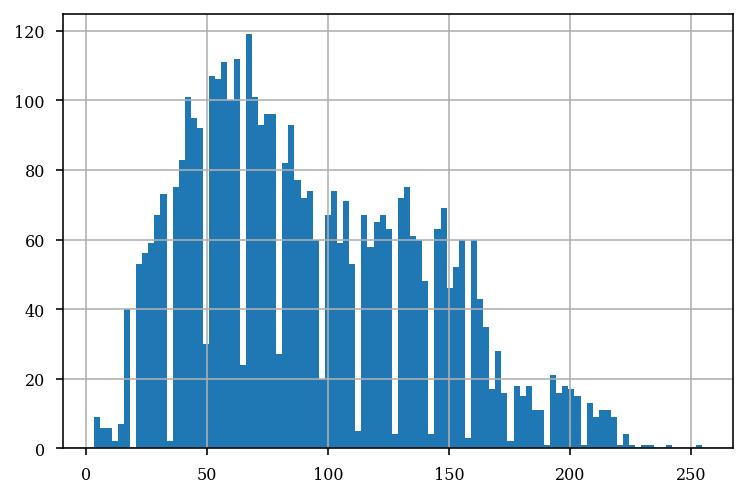

In [17]:
df
df.query("peak_rate>2 & pvals<0.05 & n_spikes > 200").field_width.hist(bins=100)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:1.152e-11 U_stat=5.115e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:5.156e-01 U_stat=4.323e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_Deep vs. 1_Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:1.312e-02 U_stat=3.918e+05


Text(279.5595465300577, 0.5, 'field width (cm)')

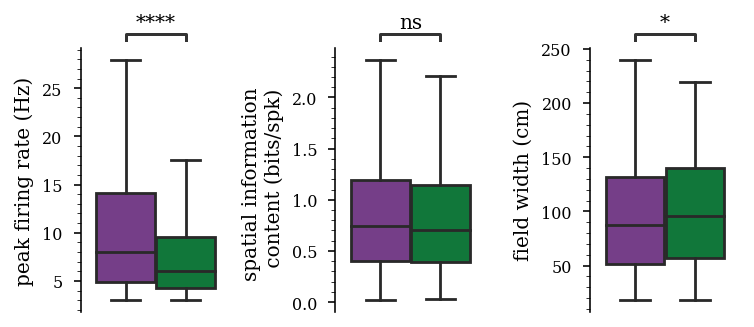

In [18]:
fig, axs = plt.subplots(
    1,
    3,
    figsize=functions.set_size("thesis", fraction=1, subplots=(2, 3)),
    edgecolor="k",
)
fig.subplots_adjust(hspace=0.1, wspace=0.7)
axs = axs.ravel()
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

df["constant"] = 1

place_cell_query = "peak_rate>3 & pvals<0.01 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna() & environment.str.contains('linear')"

sns.boxplot(
    data=df.query(place_cell_query),
    x="constant",
    y="peak_rate",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    showfliers=False,
    ax=axs[0],
)
box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    axs[0],
    box_pairs,
    data=df.query(place_cell_query),
    x="constant",
    y="peak_rate",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()


sns.boxplot(
    data=df.query(place_cell_query),
    x="constant",
    y="spatial_infos",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    showfliers=False,
    ax=axs[1],
)

box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    axs[1],
    box_pairs,
    data=df.query(place_cell_query),
    x="constant",
    y="spatial_infos",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()


sns.boxplot(
    data=df.query(place_cell_query),
    x="constant",
    y="field_width",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    showfliers=False,
    ax=axs[2],
)
box_pairs = [
    ((1, "Deep"), (1, "Superficial")),
]
annotator = Annotator(
    axs[2],
    box_pairs,
    data=df.query(place_cell_query),
    x="constant",
    y="field_width",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()


sns.despine(bottom=True)

for i in range(len(axs)):
    axs[i].legend(frameon=False)
    axs[i].get_legend().remove()
    axs[i].set_xlabel("")
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].set_ylabel("peak firing rate (Hz)")
axs[1].set_ylabel("spatial information \n content (bits/spk)")
axs[2].set_ylabel("field width (cm)")

# plt.savefig(
#     os.path.join(fig_save_path, "basic_place_cell_props.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [19]:
place_cell_query = "peak_rate>3 & pvals<0.01 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna() & environment.str.contains('linear')"

# df.query(place_cell_query)[["deepSuperficial","n_fields"]]

prop_place_fields = df.query(place_cell_query).groupby("deepSuperficial").apply(
    lambda x: pd.Series(
        {
            "n_1": sum(x.n_fields == 1),
            "n_over_1": sum(x.n_fields > 1),
            "n_overall": len(x.n_fields),
        }
    )
).reset_index()
prop_place_fields["prop_single_field"] = prop_place_fields.n_1 / prop_place_fields.n_overall
prop_place_fields["prop_multi_field"] = prop_place_fields.n_over_1 / prop_place_fields.n_overall

display(prop_place_fields)

from statsmodels.stats.proportion import proportions_ztest
count = np.array(prop_place_fields.n_1)
nobs = np.array(prop_place_fields.n_overall)
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

count = np.array(prop_place_fields.n_over_1)
nobs = np.array(prop_place_fields.n_overall)
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

,deepSuperficial,n_1,n_over_1,n_overall,prop_single_field,prop_multi_field
0,Deep,1287,631,1918,0.671011,0.328989
1,Superficial,331,111,442,0.748869,0.251131


-3.1783345560536613 0.0014812372585667419
3.1783345560536613 0.0014812372585667419


Text(0.5, 0, '')

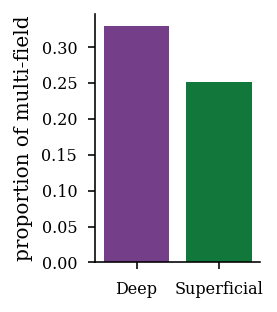

In [20]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=.25, subplots=(2.5,1)),
    edgecolor=None,
)
sns.barplot(data=prop_place_fields,x="deepSuperficial",y="prop_multi_field")
sns.despine()
plt.ylabel("proportion of multi-field")
plt.xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "proportion_multi_place_field.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [38]:
place_cell_query = "peak_rate>3 & pvals<0.01 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna() & environment.str.contains('linear')"

df.query(place_cell_query).deepSuperficial.value_counts()

Deep           1918
Superficial     442
Name: deepSuperficial, dtype: int64

### need to grouby basepath in order to account for multiple templates on linear track

In [47]:
df_groupby = df.query(place_cell_query).groupby(["basepath", "deepSuperficial"]).apply(
    lambda x: pd.Series({"n_place_cells": x.UID.nunique()})
).reset_index()
# df_groupby.deepSuperficial.value_counts()
df_groupby.groupby("deepSuperficial").n_place_cells.sum()

deepSuperficial
Deep           1017
Superficial     252
Name: n_place_cells, dtype: int64

In [23]:
df.query(place_cell_query).animal_id.nunique()


20

In [123]:
df.query(place_cell_query)[["basepath","deepSuperficial"]].value_counts()

basepath                                       deepSuperficial
Z:\Data\GirardeauG\Rat11\Rat11-20150331        Deep               100
Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  Deep                88
Z:\Data\GrosmarkAD\Achilles\Achilles_11012013  Deep                54
Z:\Data\Kenji\ec014.459_480                    Deep                50
Z:\Data\GirardeauG\Rat10\Rat10-20140620        Deep                48
                                                                 ... 
Z:\Data\AYAold\AB1\day1                        Superficial          1
Z:\Data\AYAold\AYA4\day150728                  Superficial          1
Z:\Data\GirardeauG\Rat11\Rat11-20150312        Superficial          1
Z:\Data\GirardeauG\Rat08\Rat08-20130709        Superficial          1
Z:\Data\AYAold\AYA4\day150804                  Superficial          1
Length: 146, dtype: int64

<AxesSubplot:xlabel='field_width', ylabel='peak_rate'>

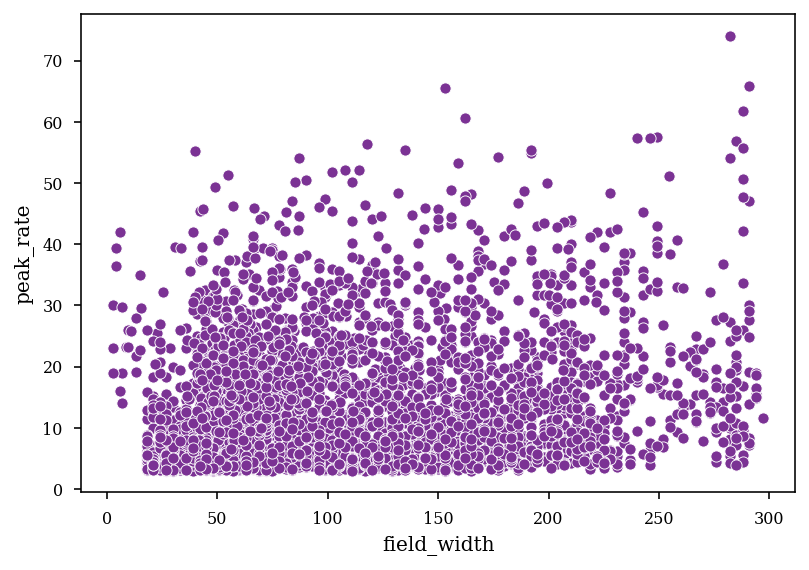

In [73]:
place_cell_query = "peak_rate>3 & pvals<0.05 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna()"

sns.scatterplot(data=df.query(place_cell_query),x="field_width",y="peak_rate")

<AxesSubplot:>

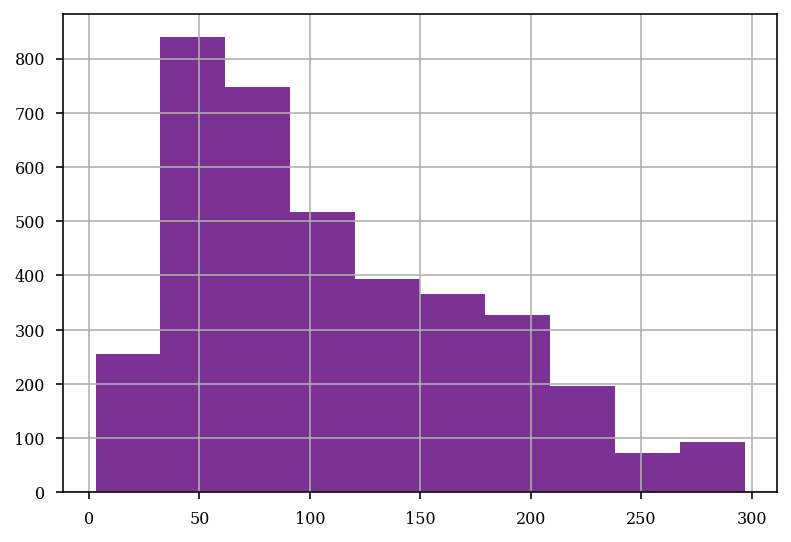

In [60]:
place_cell_query = "peak_rate>3 & pvals<0.05 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna()"
df.query(place_cell_query).field_width.hist()


<AxesSubplot:xlabel='peak_rate', ylabel='field_width'>

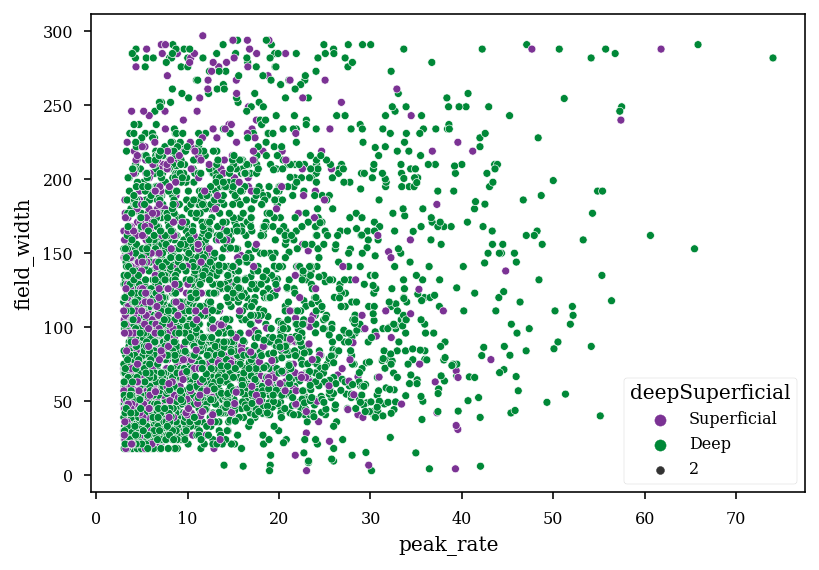

In [62]:
sns.scatterplot(data=df.query(
        "peak_rate>3 & pvals<0.05 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna()"
    ),
    x="peak_rate",
    y="field_width",
    hue="deepSuperficial",
    size=2
    )
# plt.xscale("log")
# plt.yscale("log")


<AxesSubplot:xlabel='environment', ylabel='field_width'>

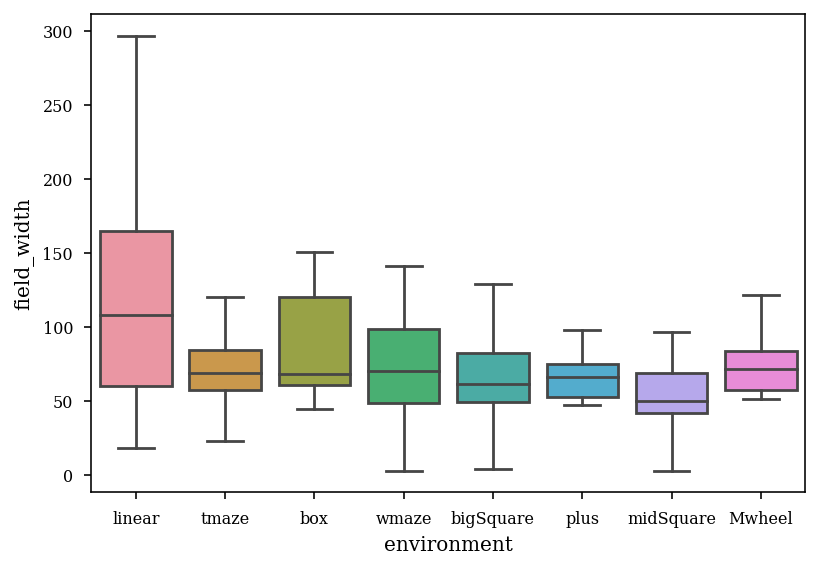

In [63]:
sns.boxplot(
    data=df.query(
        "peak_rate>3 & pvals<0.05 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna()"
    ),
    x="environment",
    y="field_width",
    showfliers=False
)

<AxesSubplot:xlabel='constant', ylabel='field_width'>

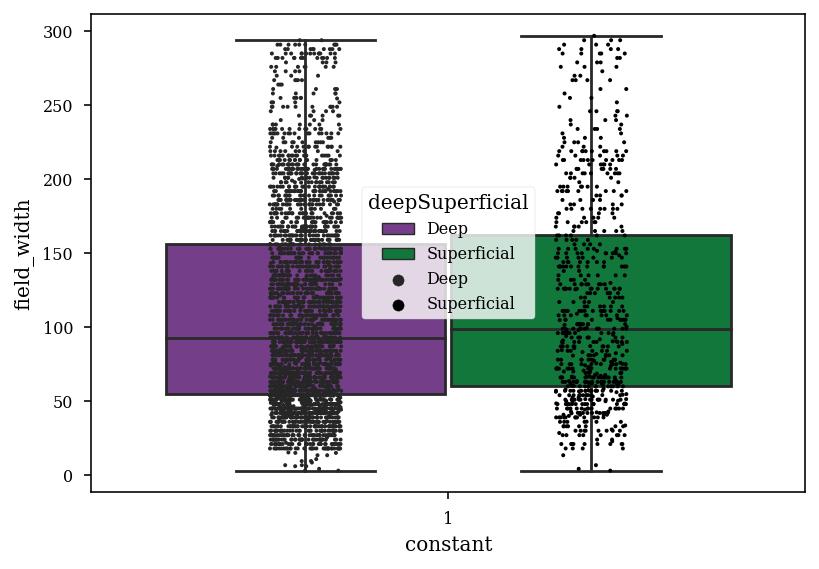

In [64]:
place_cell_query = "peak_rate>3 & pvals<0.01 & n_spikes > 200 & deepSuperficial !='middle' & not field_width.isna()"

sns.boxplot(
    data=df.query(place_cell_query),
    x="constant",
    y="field_width",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    showfliers=False,
)
sns.stripplot(
    data=df.query(place_cell_query),
    x="constant",
    y="field_width",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    dodge=True,
    color="k",
    size=2
)

Text(0, 0.5, '')

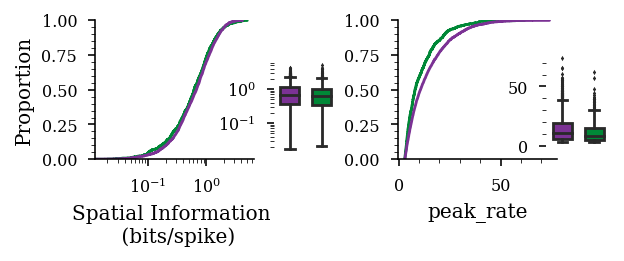

In [30]:
fig, axs = plt.subplots(
    1,
    2,
    figsize=functions.set_size("thesis", fraction=.7, subplots=(1, 2)),
    edgecolor="k",
)
fig.subplots_adjust(hspace=0, wspace=0.9)
axs = axs.ravel()

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

box_ax = custom_plots.plot_ecdf_box(
    df[(df.peak_rate > 1) & (df.pvals < 0.05) & (df.n_spikes > 200)],
    x="spatial_infos",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=0.3,
    ax=axs[0],
    fig = fig
)
axs[0].set_xscale("log")
box_ax.set_yscale("log")
axs[0].set_xlabel("Spatial Information \n (bits/spike)")

custom_plots.plot_ecdf_box(
    df[(df.peak_rate > 1) & (df.pvals < 0.05) & (df.n_spikes > 200)],
    x="peak_rate",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=0.25,
    y_offset=0.07,
    ax=axs[1],
    fig = fig
)
# axs[1].set_xscale("log")
axs[1].set_ylabel("")
# box_ax.set_yscale("log")
# ax.set_title("place cells")
# box_ax.legend(loc="upper right")

# plt.savefig(
#     os.path.join(fig_save_path, "place_cell_info_fr.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

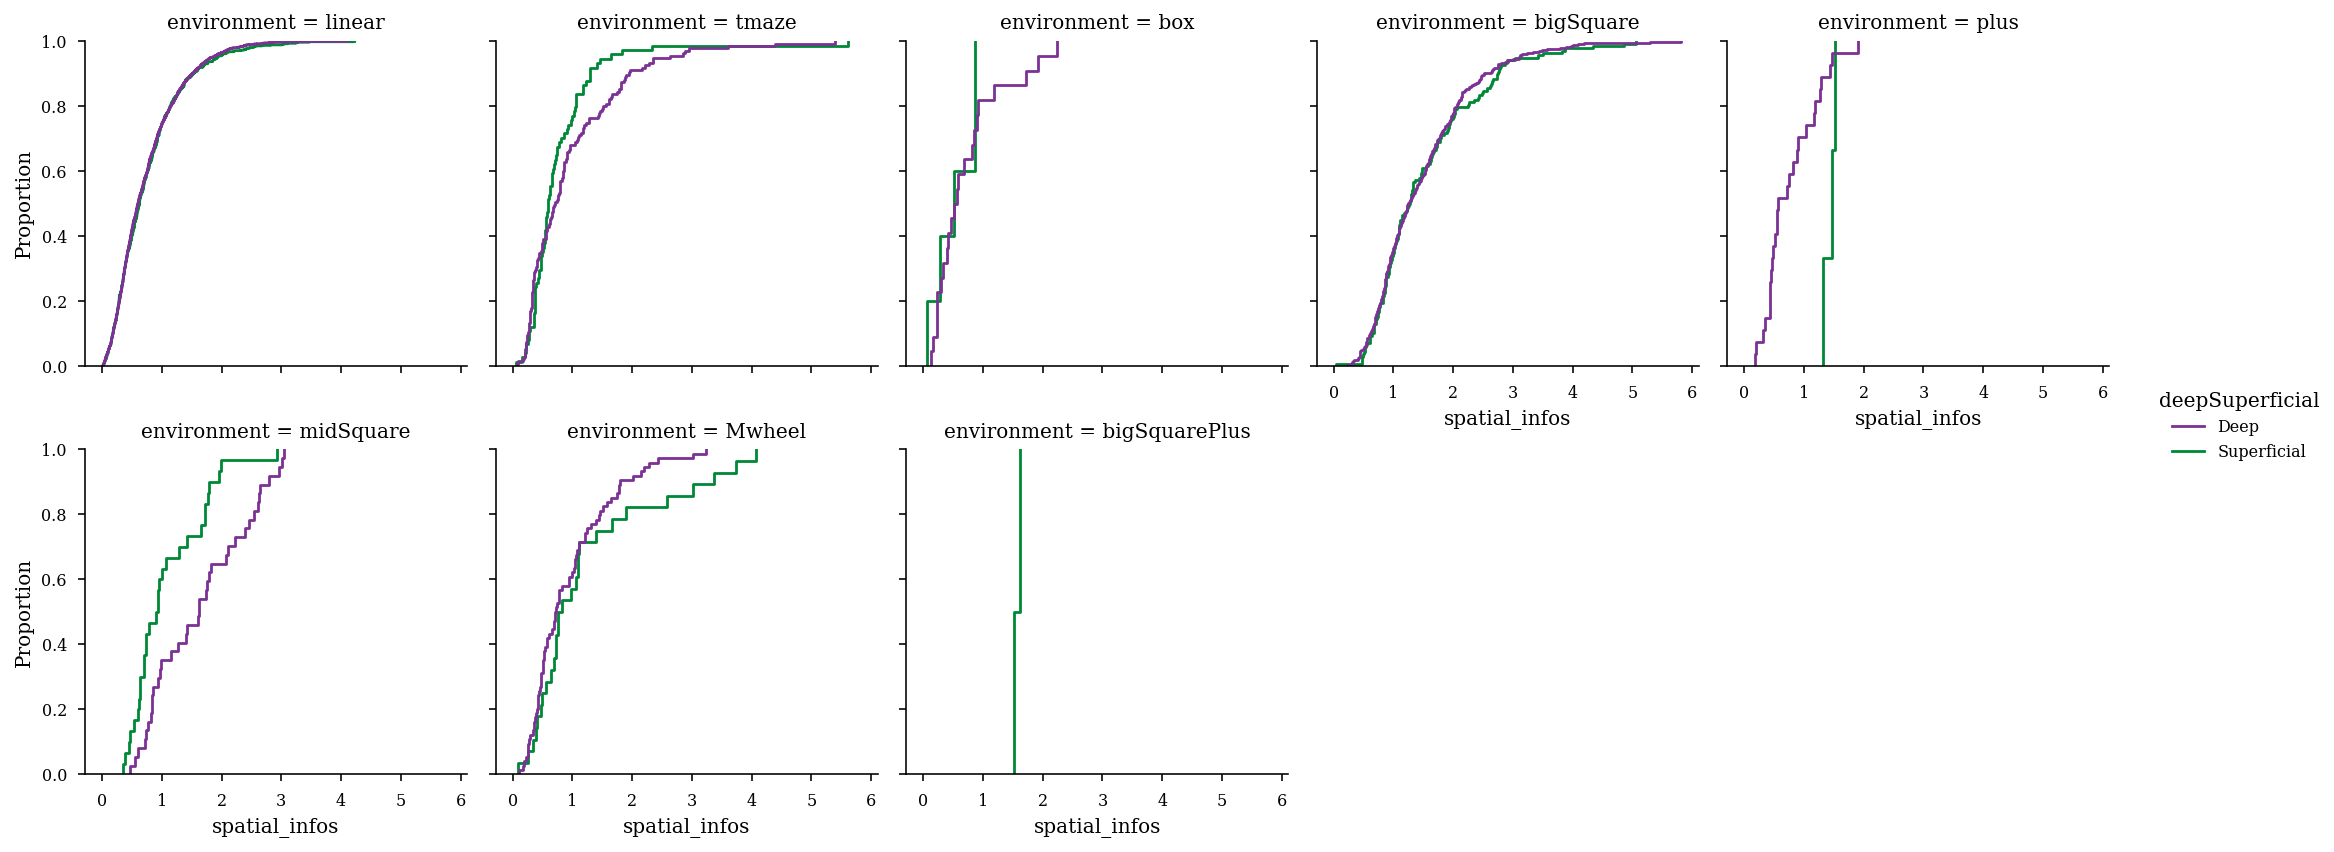

In [112]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.displot(
    df[(df.peak_rate > 1) & (df.pvals < 0.05) & (df.n_spikes > 200)],
    x="spatial_infos",
    col="environment",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    height=3,
    kind="ecdf",
    col_wrap=5,
)


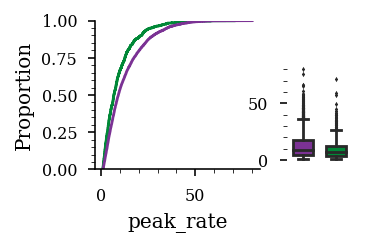

In [8]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(1.5, 1)),
    edgecolor=None,
)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
box_ax = custom_plots.plot_ecdf_box(
    df[(df.peak_rate > 1) & (df.pvals < 0.05) & (df.n_spikes > 200)],
    x="peak_rate",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=0.9,
    ax=ax,
)

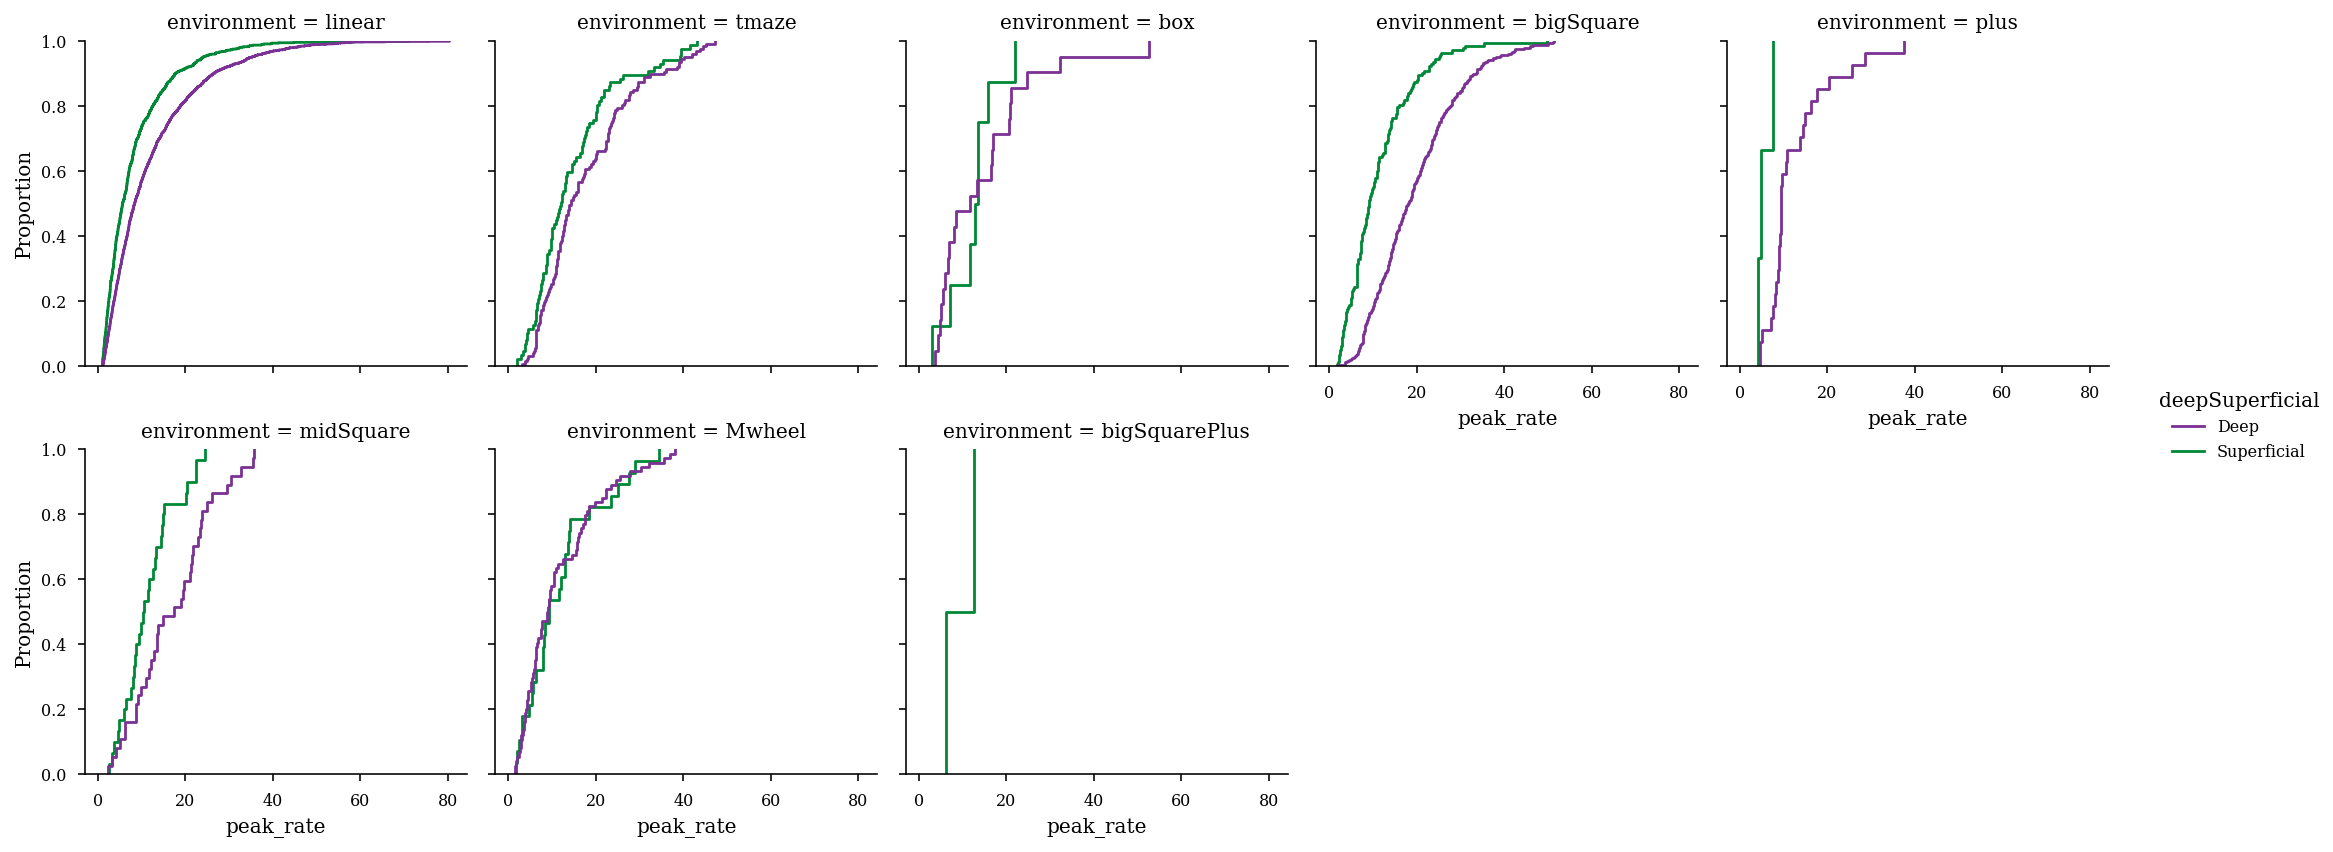

In [26]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.displot(
    df[(df.peak_rate > 1) & (df.pvals < 0.05) & (df.n_spikes > 200)],
    x="peak_rate",
    col="environment",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    height=3,
    kind="ecdf",
    col_wrap=5,
)

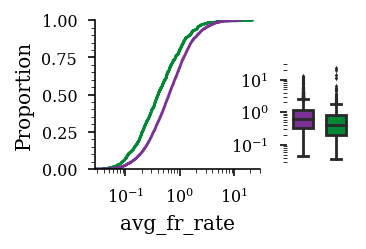

In [9]:
plt.figure(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(1.5, 1)),
    edgecolor=None,
)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
box_ax = custom_plots.plot_ecdf_box(
    df[(df.peak_rate > 1) & (df.pvals < 0.05) & (df.n_spikes > 200)],
    x="avg_fr_rate",
    hue="deepSuperficial",
    hue_order=group_colors.keys(),
    x_offset=0.9,
    ax=ax,
)
ax.set_xscale("log")
box_ax.set_yscale("log")

## proportion of place cells

In [24]:
df[["basepath","environment"]].value_counts()

basepath                                       environment
Z:\Data\GrosmarkAD\Achilles\Achilles_10252013  linear         482
Z:\Data\GirardeauG\Rat11\Rat11-20150331        linear         276
Z:\Data\HMC1\day13                             linear         242
Z:\Data\Kenji\ec013.393_418                    linear         240
Z:\Data\HMC1\day10                             linear         190
                                                             ... 
Z:\Data\Kenji\ec014.398_425                    Mwheel           4
Z:\Data\GirardeauG\Rat11\Rat11-20150323        linear           4
Z:\Data\Kenji\ec013.839_851                    bigSquare        3
Z:\Data\Kenji\ec014.120_130                    Mwheel           2
Z:\Data\Kenji\ec013.853_866                    bigSquare        1
Length: 187, dtype: int64

In [62]:
# for basepath in df.basepath.unique():
#     df.loc[df.basepath==basepath,"animal"] = loading.get_animal_id(basepath)

In [26]:
df.query("pvals < 0.01 & peak_rate > 1 & n_spikes > 200").animal_id.unique()

array(['AB1', 'AB3', 'AYA10', 'AYA4', 'AYA6', 'AYA7', 'AYA9', 'OML22',
       'OML23', 'EE', 'FF', 'GG', 'Rat08', 'Rat10', 'Rat11', 'Achilles',
       'Buddy', 'Cicero', 'Gatsby', 'HMC1', 'HMC2', 'ec013', 'ec014',
       'Kenji', 'ec016'], dtype=object)

,n_cells,deepSuperficial,place_cell_n,place_cell_prop
0,2490,CA1deep,1183,0.475100
1,1146,CA1sup,322,0.280977


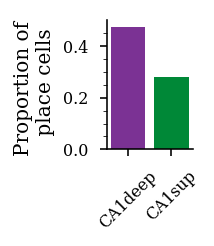

In [52]:
df_counts = (
    df.query("deepSuperficial!= 'middle'")
    .groupby(["basepath", "UID", "deepSuperficial"])
    .apply(lambda x: len(x))
    .reset_index()
)
# (df_counts.query("deepSuperficial=='Deep'")[0] > 0).sum(), (df_counts.query("deepSuperficial=='Superficial'")[0] > 0).sum(),

df_comp = pd.DataFrame()
df_comp["n_cells"] = np.array(
    [
        (df_counts.query("deepSuperficial=='Deep'")[0] > 0).sum(),
        (df_counts.query("deepSuperficial=='Superficial'")[0] > 0).sum(),
    ]
)
df_comp["deepSuperficial"] = ["CA1deep", "CA1sup"]

df_counts = (
    df.query(
        "pvals < 0.01 & peak_rate > 3 & n_spikes > 200 & deepSuperficial!= 'middle'"
    )
    .groupby(["basepath", "UID", "deepSuperficial"])
    .apply(lambda x: len(x))
    .reset_index()
)

df_comp["place_cell_n"] = np.array(
    [
        (df_counts.query("deepSuperficial=='Deep'")[0] > 0).sum(),
        (df_counts.query("deepSuperficial=='Superficial'")[0] > 0).sum(),
    ]
)
df_comp["place_cell_prop"] = df_comp["place_cell_n"] / df_comp["n_cells"]
display(df_comp)

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.13, subplots=(2.5, 1)),
    edgecolor=None,
)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))
ax = plt.gca()

ax.bar(
    df_comp["deepSuperficial"], df_comp["place_cell_prop"], color=group_colors.values()
)

ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.set_ylabel("Proportion of \n place cells")

# ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

# ax.get_legend().remove()
# ax.set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "prop_place_cells_deep_sup.svg"),
    dpi=300,
    bbox_inches="tight",
)


In [48]:
df_groupby = (
    df.query(
        "pvals < 0.01 & peak_rate > 3 & n_spikes > 200 & deepSuperficial!= 'middle'"
    )
    .groupby(["basepath", "deepSuperficial"])
    .apply(lambda x: pd.Series({"n_place_cells": x.UID.nunique()}))
    .reset_index()
)
# df_groupby.deepSuperficial.value_counts()
df_groupby.groupby("deepSuperficial").n_place_cells.sum()


deepSuperficial
Deep           1183
Superficial     322
Name: n_place_cells, dtype: int64

In [55]:
df.query(
    "pvals < 0.01 & peak_rate > 3 & n_spikes > 200 & deepSuperficial!= 'middle'"
).animal_id.nunique()

25

In [1]:
1286+359

1645

In [53]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(df_comp.place_cell_n, df_comp.n_cells)
stat, pval

(11.041323608651021, 2.4144991378570927e-28)

In [128]:
# n_deep = sum((df.deepSuperficial == "Deep"))
# n_deep_place_cell = sum((df.pvals < 0.05) & (df.peak_rate > 1) & (df.n_spikes > 200) & (df.deepSuperficial == "Deep"))
# n_sup = sum((df.deepSuperficial == "Superficial"))
# n_sup_place_cell = sum((df.pvals < 0.05) & (df.peak_rate > 1) & (df.n_spikes > 200) & (df.deepSuperficial == "Superficial"))

# df_comp = pd.DataFrame()
# df_comp["n_cells"] = np.array([n_deep, n_sup])
# df_comp["deepSuperficial"] = ['Deep','Superficial']
# df_comp["place_cell_n"] = np.array([n_deep_place_cell, n_sup_place_cell])
# df_comp["place_cell_prop"] = df_comp["place_cell_n"] / df_comp["n_cells"]

# display(df_comp)

# plt.figure(
#     figsize=functions.set_size("thesis", fraction=0.2, subplots=(1, 1)),
#     edgecolor=None,
# )
# group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
# sns.set_palette(sns.color_palette(group_colors.values()))
# ax = plt.gca()

# ax.barh(df_comp["deepSuperficial"], df_comp["place_cell_prop"], color=group_colors.values())

# ax.xaxis.set_minor_locator(AutoMinorLocator())

# ax.set_xlabel("Proportion of \n place cells")

# ax.yaxis.set_minor_locator(AutoMinorLocator())
# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# # ax.get_legend().remove()
# # ax.set_xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "prop_place_cells_deep_sup.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


In [11]:
2404+4559

6963

## plot place cells

In [ ]:
place_cell_df = df[(df.pvals < 0.05) & (df.peak_rate > 1) & (df.n_spikes > 200)]
place_save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\place_cell_examples"
)
for basepath in place_cell_df.basepath.unique():
    for UID in place_cell_df[place_cell_df.basepath == basepath].UID.unique():
        
        axs, fig = place_cell_plots.run(basepath, UID, save_path)

        save_file = os.path.join(
            place_save_path,
            basepath.replace(os.sep, "_").replace(":", "_")
            + "_"
            + str(UID)
            + ".jpeg",
        )

        plt.savefig(save_file, dpi=300, bbox_inches="tight")
        plt.close()

# basepath = "Z:\\Data\\Kenji\\ec013.779_791"
# UID = 52.0
# place_cell_plots.run(basepath, UID, save_path)


In [ ]:
# # df = add_new_deep_sup.add_new_deep_sup_class(df)
# cell_metrics = loading.load_all_cell_metrics(df.basepath.unique())
# cell_metrics

In [ ]:
# basepath = df.basepath.unique()[1]
# # for basepath in df.basepath.unique():
# cell_metrics_temp = cell_metrics[cell_metrics.basepath == basepath]
# cell_metrics_temp.reset_index(inplace=True)

# df_temp = df[df.basepath == basepath]
# df_temp.reset_index(inplace=True)
# # cell_metrics_temp.UID
# # df_temp.UID

# a,b,c = np.intersect1d(cell_metrics_temp.UID, df_temp.UID, return_indices=True)
# a,b,c

## keep sessions with more than 1 epoch

In [56]:
keep = []
for basepath in df.basepath:
    epoch_types = df[(df.basepath == basepath)].environment.unique()
    keep.append(sum((epoch_types != "sleep")) > 1)
df = df[keep]


In [68]:
print(df.environment.unique())
# print(df.behavioralParadigm.unique())
print(df.basepath.unique())
print(df.basepath.nunique())
print(df.animal_id.nunique())


df_groupby = (
    df.query(
        "pvals < 0.01 & peak_rate > 1 & n_spikes > 100 & deepSuperficial!= 'middle'"
    )
    .groupby(["basepath", "deepSuperficial"])
    .apply(lambda x: pd.Series({"n_place_cells": x.UID.nunique()}))
    .reset_index()
)
# df_groupby.deepSuperficial.value_counts()
df_groupby.groupby("deepSuperficial").n_place_cells.sum()

['tmaze' 'linear' 'box' 'wmaze' 'bigSquare' 'plus' 'midSquare' 'Mwheel'
 'bigSquarePlus']
['Z:\\Data\\AYAold\\AB3\\AB3_38_41' 'Z:\\Data\\AYAold\\AB3\\AB3_42_46'
 'Z:\\Data\\AYAold\\AYA9\\day12' 'Z:\\Data\\HMC2\\day11'
 'Z:\\Data\\HMC2\\day8' 'Z:\\Data\\HMC2\\day9'
 'Z:\\Data\\Kenji\\ec013.152_157' 'Z:\\Data\\Kenji\\ec013.194_213'
 'Z:\\Data\\Kenji\\ec013.242_258' 'Z:\\Data\\Kenji\\ec013.370_390'
 'Z:\\Data\\Kenji\\ec013.393_418' 'Z:\\Data\\Kenji\\ec013.421_447'
 'Z:\\Data\\Kenji\\ec013.451_470' 'Z:\\Data\\Kenji\\ec013.480_509'
 'Z:\\Data\\Kenji\\ec013.512_537' 'Z:\\Data\\Kenji\\ec013.540_561'
 'Z:\\Data\\Kenji\\ec013.564_585' 'Z:\\Data\\Kenji\\ec013.588_604'
 'Z:\\Data\\Kenji\\ec013.608_632' 'Z:\\Data\\Kenji\\ec013.634_653'
 'Z:\\Data\\Kenji\\ec013.656_674' 'Z:\\Data\\Kenji\\ec013.677_699'
 'Z:\\Data\\Kenji\\ec013.702_724' 'Z:\\Data\\Kenji\\ec013.733_746'
 'Z:\\Data\\Kenji\\ec013.752_769' 'Z:\\Data\\Kenji\\ec013.779_791'
 'Z:\\Data\\Kenji\\ec013.793_814' 'Z:\\Data\\Kenji\\ec013.816_835

deepSuperficial
Deep           169
Superficial     70
Name: n_place_cells, dtype: int64

In [69]:
169 + 70

239

## Get prop of sig place cell per session 

In [59]:
df

,UID,environment,name,startTime,stopTime,spatial_infos,pvals,field_width,peak_rate,n_fields,linear_dir,basepath,n_spikes,deepSuperficialDistance,brainRegion,deepSuperficial,avg_fr_rate,animal_id,constant
118,1,tmaze,tmaze,2520.000,3600.000,0.213002,0.004435,NaN,NaN,NaN,NaN,Z:\Data\AYAold\AB3\AB3_38_41,1513,-305.674904,CA1so,Deep,1.400926,AB3,1
119,2,tmaze,tmaze,2520.000,3600.000,0.836928,0.002217,NaN,NaN,NaN,NaN,Z:\Data\AYAold\AB3\AB3_38_41,673,-255.674904,CA1so,Deep,0.623148,AB3,1
120,3,tmaze,tmaze,2520.000,3600.000,0.191093,0.004435,153.733536,29.628134,1.0,NaN,Z:\Data\AYAold\AB3\AB3_38_41,3200,-305.674904,CA1so,Deep,2.962963,AB3,1
121,4,tmaze,tmaze,2520.000,3600.000,0.343073,0.004435,NaN,NaN,NaN,NaN,Z:\Data\AYAold\AB3\AB3_38_41,1951,-355.674904,CA1so,Deep,1.806481,AB3,1
122,5,tmaze,tmaze,2520.000,3600.000,0.319720,0.002217,NaN,NaN,NaN,NaN,Z:\Data\AYAold\AB3\AB3_38_41,1277,-205.674904,CA1so,Deep,1.182407,AB3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12019,90,bigSquare,ec013.890_bigSquare,25363.595,26655.064,1.297976,0.002217,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec013.868_893,387,60.000000,CA1,Superficial,0.299659,ec013,1
12020,92,bigSquare,ec013.890_bigSquare,25363.595,26655.064,1.131487,0.002217,62.641839,22.576460,2.0,NaN,Z:\Data\Kenji\ec013.868_893,2470,0.000000,CA1,middle,1.912551,ec013,1
12021,99,bigSquare,ec013.890_bigSquare,25363.595,26655.064,1.124255,0.106430,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec013.868_893,426,-20.000000,CA1,middle,0.329857,ec013,1
12022,100,bigSquare,ec013.890_bigSquare,25363.595,26655.064,1.088016,0.002217,NaN,NaN,NaN,NaN,Z:\Data\Kenji\ec013.868_893,518,80.000000,CA1,Superficial,0.401094,ec013,1


In [60]:
df_unit = df.groupby(["basepath", "UID", "deepSuperficial"]).apply(
    lambda x: pd.Series(
        {
            "n_fields": (
                (x.pvals.values <= 0.01)
                & (x.n_spikes.values >= 100) 
                & (x.peak_rate.values >= 1)
            ).sum(),
            "n_env": len(x)
        }
    )
).reset_index()
df_unit["sig_pc_prop"] = df_unit.n_fields / df_unit.n_env
df_unit

,basepath,UID,deepSuperficial,n_fields,n_env,sig_pc_prop
0,Z:\Data\AYAold\AB3\AB3_38_41,1,Deep,1,3,0.333333
1,Z:\Data\AYAold\AB3\AB3_38_41,2,Deep,1,3,0.333333
2,Z:\Data\AYAold\AB3\AB3_38_41,3,Deep,2,3,0.666667
3,Z:\Data\AYAold\AB3\AB3_38_41,4,Deep,2,3,0.666667
4,Z:\Data\AYAold\AB3\AB3_38_41,5,Deep,1,3,0.333333
...,...,...,...,...,...,...
549,Z:\Data\Kenji\ec013.868_893,90,Superficial,4,12,0.333333
550,Z:\Data\Kenji\ec013.868_893,92,middle,10,12,0.833333
551,Z:\Data\Kenji\ec013.868_893,99,middle,4,12,0.333333
552,Z:\Data\Kenji\ec013.868_893,100,Superficial,3,12,0.250000


In [61]:
df_unit.query("deepSuperficial=='Deep'").n_fields.sum(), df_unit.query("deepSuperficial=='Deep'").n_env.sum()

(691, 1607)

RanksumsResult(statistic=2.727893069437069, pvalue=0.006374026653382701)

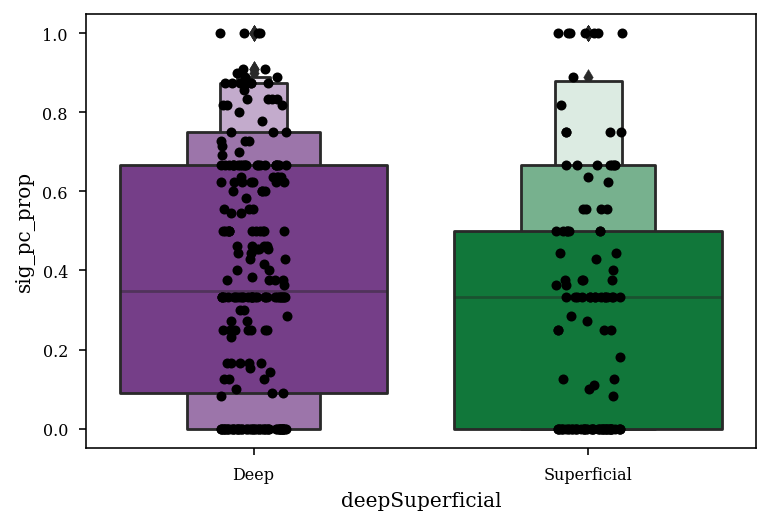

In [62]:
sns.boxenplot(data=df_unit.query("deepSuperficial != 'middle'"),x="deepSuperficial",y="sig_pc_prop")
sns.stripplot(data=df_unit.query("deepSuperficial != 'middle'"),x="deepSuperficial",y="sig_pc_prop",color="k")

from scipy.stats import ranksums
ranksums(df_unit.query("deepSuperficial == 'Deep'").sig_pc_prop, df_unit.query("deepSuperficial == 'Superficial'").sig_pc_prop)

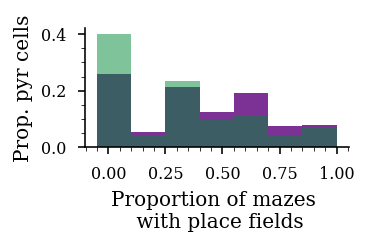

In [63]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}

from matplotlib.ticker import AutoMinorLocator

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 2)), edgecolor="k"
)

bin_width = 0.15
bins = np.arange(0, 1.2, bin_width) - 0.05
binned, _ = np.histogram(
    df_unit[df_unit.deepSuperficial == "Deep"].sig_pc_prop, bins=bins
)
plt.bar(
    bins[:-1] + bin_width / 2, binned / binned.sum(), width=bin_width, color="#7b3294"
)

binned, _ = np.histogram(
    df_unit[df_unit.deepSuperficial == "Superficial"].sig_pc_prop, bins=bins
)
plt.bar(
    bins[:-1] + bin_width / 2,
    binned / binned.sum(),
    width=bin_width,
    color="#008837",
    alpha=0.5,
)

plt.xlabel("Proportion of mazes \n with place fields")
plt.ylabel("Prop. pyr cells")

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# plt.savefig(
#     os.path.join(fig_save_path, "place_cell_prop_deep_sup_v2.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


In [67]:
df_unit = functions.add_animal_id(df_unit)
df_unit.animal_id.unique()

array(['AB3', 'AYA9', 'HMC2', 'ec013'], dtype=object)

In [ ]:
df_unit = pd.DataFrame()
for basepath in df.basepath.unique():
    sig_pc = []
    UID = []
    for env in df[(df.basepath == basepath)].name.unique():
        UID.append(df[(df.basepath == basepath) & (df.name == env)].UID.values)

        sig_pc.append(
            (df[(df.basepath == basepath) & (df.name == env)].pvals.values <= 0.01)
            & (df[(df.basepath == basepath) & (df.name == env)].n_spikes.values >= 100)
            & (df[(df.basepath == basepath) & (df.name == env)].peak_rate.values >= 1)
        )
    sig_pc = np.array(sig_pc)

    df1 = pd.DataFrame()
    df1["sig_pc_prop"] = sig_pc.sum(axis=0) / sig_pc.shape[0]
    df1["UID"] = UID[0]
    df1["basepath"] = basepath
    df1["n_epochs"] = len(UID)

    df_unit = df_unit.append(df1, ignore_index=True)

df_unit


## Probability of displaying place field in each epoch

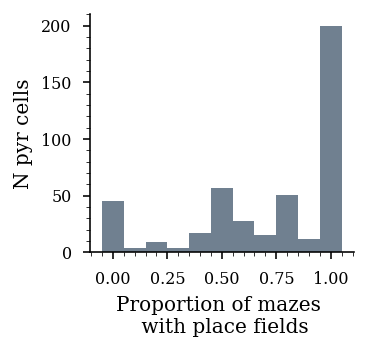

In [35]:
from matplotlib.ticker import AutoMinorLocator

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 1)), edgecolor="k"
)

bin_width = 0.1
bins = np.arange(0, 1.2, bin_width) - 0.05
binned, _ = np.histogram(df_unit.sig_pc_prop, bins=bins)

plt.bar(bins[:-1] + bin_width / 2, binned, width=bin_width, color="slategrey")

plt.xlabel("Proportion of mazes \n with place fields")
plt.ylabel("N pyr cells")

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "prob_place_cell_epochs.svg"),
    dpi=300,
    bbox_inches="tight",
)


## Cells with place fields in all mazes participation

In [36]:
ripple_particip = []
deepSuperficial = []

for df_temp in df_unit.itertuples():
    df_cell_metrics, data_ = loading.load_cell_metrics(df_temp.basepath)
    ripple_particip.append(
        df_cell_metrics[df_cell_metrics.UID == df_temp.UID].ripple_particip.values
    )
    deepSuperficial.append(
        df_cell_metrics[df_cell_metrics.UID == df_temp.UID].deepSuperficial.values
    )

df_unit["ripple_particip"] = np.vstack(ripple_particip)
df_unit["deepSuperficial"] = np.vstack(deepSuperficial)

df_unit


,sig_pc_prop,UID,basepath,n_epochs,ripple_particip,deepSuperficial
0,1.000,1.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.377517,Deep
1,1.000,2.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.229866,Deep
2,1.000,3.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.465884,Deep
3,1.000,4.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.378076,Deep
4,1.000,5.0,Z:\Data\AYAold\AB3\AB3_38_41,2,0.272371,Deep
...,...,...,...,...,...,...
437,1.000,90.0,Z:\Data\Kenji\ec013.868_893,8,0.161978,Superficial
438,0.875,92.0,Z:\Data\Kenji\ec013.868_893,8,0.442313,Deep
439,0.750,99.0,Z:\Data\Kenji\ec013.868_893,8,0.142938,Deep
440,0.500,100.0,Z:\Data\Kenji\ec013.868_893,8,0.302927,Superficial


### prop_place_fields_rip_particip weighted regression

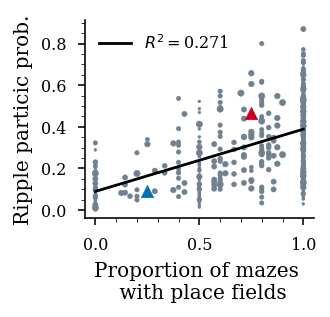

In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(1, 1)), edgecolor="k"
)
sc = plt.scatter(
    df_unit.sig_pc_prop,
    df_unit.ripple_particip,
    s=df_unit.n_epochs,
    alpha=1,
    color="slategrey",
)
plt.legend(*sc.legend_elements("sizes", num=5))

plt.xlabel("Proportion of mazes \n with place fields")
plt.ylabel("Ripple particic prob.")

# polyreg=make_pipeline(PolynomialFeatures(1),LinearRegression())
polyreg = make_pipeline(LinearRegression())
X = df_unit.sig_pc_prop.values.reshape(-1, 1)
y = df_unit.ripple_particip.values
X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
weights = df_unit.n_epochs.values

polyreg.fit(X, y, linearregression__sample_weight=weights)
plt.plot(
    X_seq,
    polyreg.predict(X_seq),
    color="black",
    label="$R^2=$" + str("%.3f" % (polyreg.score(X, y))),
)

ax = plt.gca()
ax.set_aspect("equal", "box")
ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

idx = (df_unit.basepath == "Z:\Data\Kenji\ec013.779_791") & (df_unit.UID == 43.0)
sc = plt.scatter(
    df_unit[idx].sig_pc_prop,
    df_unit[idx].ripple_particip,
    s=40,
    alpha=1,
    color="#ca0020",
    marker="^",
)

idx = (df_unit.basepath == "Z:\Data\Kenji\ec013.779_791") & (df_unit.UID == 40.0)
sc = plt.scatter(
    df_unit[idx].sig_pc_prop,
    df_unit[idx].ripple_particip,
    s=40,
    alpha=1,
    color="#0571b0",
    marker="^",
)

# ax.set_yscale('log')
plt.savefig(
    os.path.join(fig_save_path, "prop_place_fields_rip_particip.svg"),
    dpi=300,
    bbox_inches="tight",
)


<AxesSubplot:xlabel='sig_pc_prop', ylabel='particip_prob_ratio'>

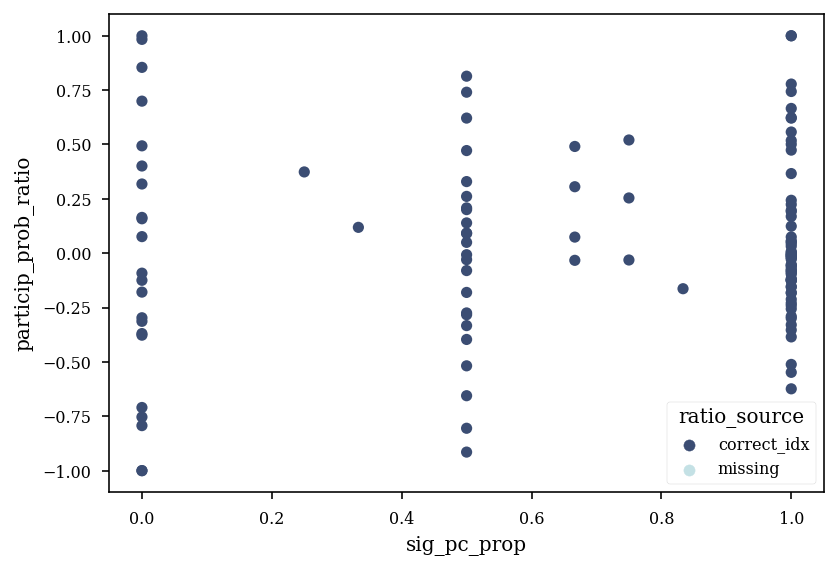

In [38]:
df_ratios = pd.read_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ripple_participation_stability_pre_task_post.csv"
)

particip_prob_ratio = []
fr_ratio = []
source = []
for temp_df in df_unit.itertuples():

    idx = (df_ratios.basepath == temp_df.basepath) & (df_ratios.UID == temp_df.UID)
    if sum(idx) > 1:
        particip_prob_ratio.append(
            np.nanmean(df_ratios[idx].particip_prob_ratio.values)
        )
        fr_ratio.append(np.nanmean(df_ratios[idx].fr_ratio.values))
        source.append("incorrect_idx")
    elif sum(idx) == 1:
        particip_prob_ratio.append(df_ratios[idx].particip_prob_ratio.values)
        fr_ratio.append(df_ratios[idx].fr_ratio.values)
        source.append("correct_idx")
    else:
        particip_prob_ratio.append(np.nan)
        fr_ratio.append(np.nan)
        source.append("missing")

df_unit["particip_prob_ratio"] = np.hstack(particip_prob_ratio)
df_unit["fr_ratio"] = np.hstack(fr_ratio)
df_unit["ratio_source"] = np.hstack(source)

sns.scatterplot(
    x="sig_pc_prop",
    y="particip_prob_ratio",
    hue="ratio_source",
    palette="ch:r=-.2,d=.3_r",
    sizes=(1, 8),
    linewidth=0,
    data=df_unit,
)
# df_unit


## Is place field propensity larger in CA1deep than CA1sup 


In [39]:
import loading


def add_rem_shift(df):

    df.loc[:, "rem_shift"] = False
    df.loc[:, "non_rem_shift"] = False
    df.loc[:, "m_wake"] = np.nan
    df.loc[:, "m_rem"] = np.nan
    df.loc[:, "p_rem"] = np.nan
    df.loc[:, "p_wake"] = np.nan
    df.loc[:, "circ_dist"] = np.nan

    for basepath in df.basepath.unique():
        df_rem_shift, _ = loading.load_theta_rem_shift(basepath)
        if df_rem_shift.shape[0] == 0:
            continue

        # restrict rem shift df to valid UIDs from df
        df_rem_shift = df_rem_shift[
            np.in1d(df_rem_shift.UID, df[df.basepath == basepath].UID)
        ]
        # get index of current basepath
        # idx = (df.basepath==basepath).values
        idx = df.basepath == basepath

        df.loc[idx, "rem_shift"] = (df_rem_shift.rem_shift == 1).values
        df.loc[idx, "non_rem_shift"] = (df_rem_shift.non_rem_shift == 1).values

        df.loc[idx, "m_rem"] = df_rem_shift.m_rem.values
        df.loc[idx, "m_wake"] = df_rem_shift.m_wake.values
        df.loc[idx, "p_rem"] = df_rem_shift.p_rem.values
        df.loc[idx, "p_wake"] = df_rem_shift.p_wake.values
        df.loc[idx, "circ_dist"] = df_rem_shift.circ_dist.values

    df.loc[df.rem_shift == True, "rem_shift"] = "rem_shifting"
    df.loc[df.rem_shift == False, "rem_shift"] = "unknown"

    df.loc[df.non_rem_shift == True, "non_rem_shift"] = "non_rem_shifting"
    df.loc[df.non_rem_shift == False, "non_rem_shift"] = "unknown"

    layer_rem_shift = []
    for temp_df in df.itertuples():
        if (temp_df.rem_shift == "rem_shifting") & (temp_df.deepSuperficial == "Deep"):
            layer_rem_shift.append("deep_rem_shift")
        elif (temp_df.non_rem_shift == "non_rem_shifting") & (
            temp_df.deepSuperficial == "Superficial"
        ):
            layer_rem_shift.append("sup_non_rem_shift")
        else:
            layer_rem_shift.append("unknown")
    df["layer_rem_shift"] = layer_rem_shift

    return df


df_unit = add_rem_shift(df_unit)


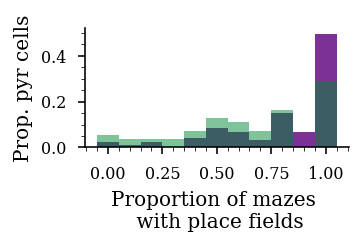

In [40]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}

from matplotlib.ticker import AutoMinorLocator

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.4, subplots=(1.5, 2)), edgecolor="k"
)

bin_width = 0.1
bins = np.arange(0, 1.2, bin_width) - 0.05
binned, _ = np.histogram(
    df_unit[df_unit.layer_rem_shift == "deep_rem_shift"].sig_pc_prop, bins=bins
)
plt.bar(
    bins[:-1] + bin_width / 2, binned / binned.sum(), width=bin_width, color="#7b3294"
)

binned, _ = np.histogram(
    df_unit[df_unit.layer_rem_shift == "sup_non_rem_shift"].sig_pc_prop, bins=bins
)
plt.bar(
    bins[:-1] + bin_width / 2,
    binned / binned.sum(),
    width=bin_width,
    color="#008837",
    alpha=0.5,
)

plt.xlabel("Proportion of mazes \n with place fields")
plt.ylabel("Prop. pyr cells")

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "place_cell_prop_deep_sup.svg"),
    dpi=300,
    bbox_inches="tight",
)


## Do cells with higher spatial specificity have the largest SWR participation increase post-task?

In [19]:
def load_in_everything(save_path):

    sessions = glob.glob(save_path + os.sep + "*.pkl")

    results = pd.DataFrame()

    for session in sessions:
        with open(session, "rb") as f:
            result = pickle.load(f)
        df1 = result["df"]

        n_spikes = [len(st) for st in result["st"]]
        df1["n_spikes"] = n_spikes
        peak_rate = []
        for map_ in result["ratemaps"]:
            if len(map_) == 0:
                peak_rate.append(0)
            else:
                peak_rate.append(map_.max())
        if len(peak_rate) == 0:
            df1["peak_rate"] = peak_rate
        else:
            df1["peak_rate"] = np.vstack(peak_rate)

        results = results.append(df1, ignore_index=True)
    return results


# load data from savepath
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell"

df = load_in_everything(save_path)


In [20]:
df_ratios = pd.read_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ripple_participation_stability_pre_task_post.csv"
)
spatial_infos = []
source = []
for temp_df in df_ratios.itertuples():
    basepath = temp_df.basepath
    idx = (
        (df.basepath == basepath)
        & (df.UID == temp_df.UID)
        & (df.environment == temp_df.task)
    )
    if sum(idx) > 1:
        spatial_infos.append(np.nanmean(df[idx].spatial_infos))
        source.append("incorrect_idx")
    elif sum(idx) == 1:
        spatial_infos.append(df[idx].spatial_infos.values)
        source.append("correct_idx")
    else:
        spatial_infos.append(np.nan)
        source.append("missing")
    # pvals

df_ratios["spatial_infos"] = np.hstack(spatial_infos)
df_ratios["source"] = np.hstack(source)

df_ratios = df_ratios[~np.isnan(df_ratios.spatial_infos)]
df_ratios


,Unnamed: 0,basepath,UID,task,n_spikes,deepSuperficial,fr_ratio,particip_prob_ratio,spatial_infos,source
0,0,Z:\Data\AYAold\AB3\AB3_38_41,1,tmaze,1602.0,Deep,0.266966,-0.124604,1.288817,correct_idx
1,1,Z:\Data\AYAold\AB3\AB3_38_41,2,tmaze,680.0,Deep,0.112032,-0.012372,3.065626,correct_idx
2,2,Z:\Data\AYAold\AB3\AB3_38_41,3,tmaze,3306.0,Deep,0.024308,-0.256041,1.025667,correct_idx
3,3,Z:\Data\AYAold\AB3\AB3_38_41,4,tmaze,2079.0,Deep,0.127765,-0.240106,1.283747,correct_idx
4,4,Z:\Data\AYAold\AB3\AB3_38_41,5,tmaze,1359.0,Deep,0.045089,-0.096372,1.215658,correct_idx
...,...,...,...,...,...,...,...,...,...,...
2891,2891,Z:\Data\Kenji\ec016.577_590,80,bigSquare,865.0,Deep,-0.170792,-0.048885,3.162609,correct_idx
2892,2892,Z:\Data\Kenji\ec016.577_590,82,bigSquare,913.0,Deep,0.562414,0.045178,0.596953,correct_idx
2893,2893,Z:\Data\Kenji\ec016.577_590,84,bigSquare,72.0,Deep,-0.934713,-0.170578,3.389118,correct_idx
2894,2894,Z:\Data\Kenji\ec016.577_590,86,bigSquare,799.0,Deep,-0.223416,0.018549,2.301927,correct_idx


<AxesSubplot:xlabel='spatial_infos', ylabel='particip_prob_ratio'>

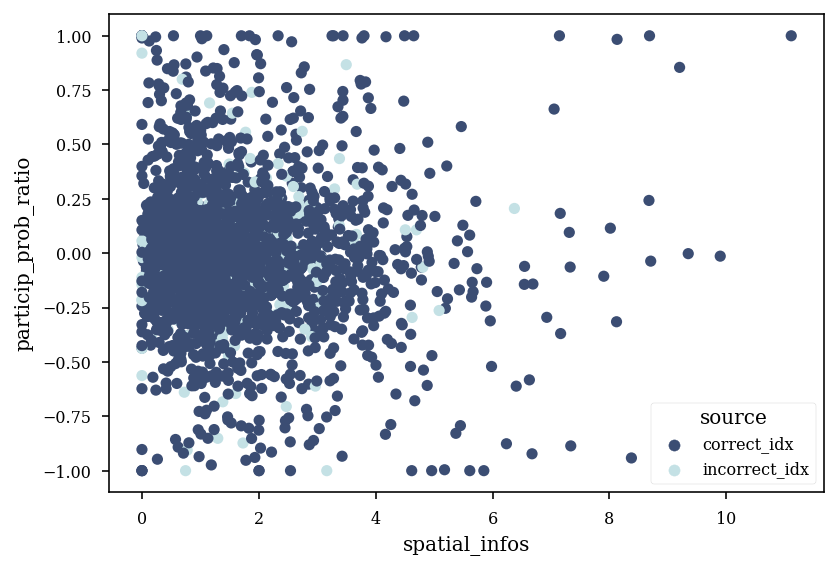

In [25]:
sns.scatterplot(
    x="spatial_infos",
    y="particip_prob_ratio",
    hue="source",
    palette="ch:r=-.2,d=.3_r",
    sizes=(1, 8),
    linewidth=0,
    data=df_ratios,
)


No handles with labels found to put in legend.


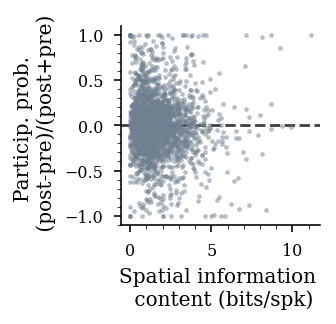

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(1, 1)), edgecolor="k"
)
plt.scatter(
    df_ratios.spatial_infos,
    df_ratios.particip_prob_ratio,
    alpha=0.5,
    s=4,
    color="slategrey",
    rasterized=True,
)

plt.xlabel("Spatial information \n content (bits/spk)")
plt.ylabel("Particip. prob. \n (post-pre)/(post+pre)")

# polyreg=make_pipeline(LinearRegression())
# polyreg=make_pipeline(PolynomialFeatures(1),RANSACRegressor())
polyreg = make_pipeline(RANSACRegressor())

X = df_ratios.spatial_infos.values.reshape(-1, 1)
y = df_ratios.particip_prob_ratio.values
good_idx = ~np.isnan(X.T) & ~np.isnan(y)
X = X[good_idx[0]]
y = y[good_idx[0]]
X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

polyreg.fit(X, y)
# plt.plot(X_seq,polyreg.predict(X_seq),color="black",label='$R^2=$'+str('%.3f'%(polyreg.score(X,y))))

plt.ylim(-1.1, 1.1)
ax = plt.gca()

ax.axhline(0, color="k", ls="--", alpha=0.75, zorder=-100)

# ax.set_aspect('equal', 'box')
ax.set_aspect(1.0 / ax.get_data_ratio())

ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "partic_gain_spatial_info.svg"),
    dpi=300,
    bbox_inches="tight",
)


No handles with labels found to put in legend.


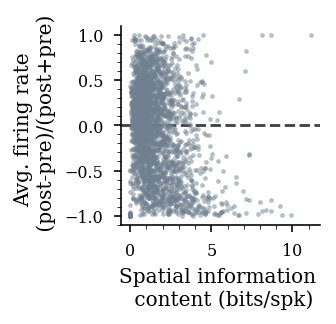

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(1, 1)), edgecolor="k"
)
plt.scatter(
    df_ratios.spatial_infos,
    df_ratios.fr_ratio,
    alpha=0.5,
    s=4,
    color="slategrey",
    rasterized=True,
)

plt.xlabel("Spatial information \n content (bits/spk)")
plt.ylabel("Avg. firing rate \n (post-pre)/(post+pre)")

polyreg = make_pipeline(RANSACRegressor())
X = df_ratios.spatial_infos.values.reshape(-1, 1)
y = df_ratios.fr_ratio.values
good_idx = ~np.isnan(X.T) & ~np.isnan(y)
X = X[good_idx[0]]
y = y[good_idx[0]]
X_seq = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

polyreg.fit(X, y)
# plt.plot(X_seq,polyreg.predict(X_seq),color="black",label='$R^2=$'+str('%.3f'%(polyreg.score(X,y))))

plt.ylim(-1.1, 1.1)
ax = plt.gca()

ax.axhline(0, color="k", ls="--", alpha=0.75, zorder=-100)

# ax.set_xscale('log')

# ax.set_aspect('equal', 'box')
ax.set_aspect(1.0 / ax.get_data_ratio())

ax.legend(frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "fr_gain_spatial_info.svg"),
    dpi=300,
    bbox_inches="tight",
)


## Place cell example figure

In [ ]:
def plot_place_cells(basepath, unit_id, save_path):
    save_file = os.path.join(
        save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
    )

    beh_df = loading.load_animal_behavior(basepath)

    epoch_df = loading.load_epoch(basepath)
    # remove sleep and wheel running
    epoch_df = epoch_df[
        (epoch_df.environment != "sleep") & (epoch_df.environment != "wheel")
    ]
    # remove sessions < 5 minutes
    epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime) / 60 > 5]

    with open(save_file, "rb") as f:
        result = pickle.load(f)

    ratemaps = np.array(result["ratemaps"])[result["df"]["UID"] == unit_id]
    occ = np.array(result["occupancies"])[result["df"]["UID"] == unit_id]

    # x = np.array(result['x'])[result['df']['UID'] == unit_id]
    # y = np.array(result['y'])[result['df']['UID'] == unit_id]
    name = result["df"].name.values[result["df"]["UID"] == unit_id]
    st = np.array(result["st"])[result["df"]["UID"] == unit_id]

    # n_panels = int(np.ceil(len(ratemaps)/2))
    n_panels = len(ratemaps)
    fig, axs = plt.subplots(
        2,
        n_panels,
        figsize=functions.set_size("thesis", fraction=1.25, subplots=(3, n_panels)),
        edgecolor="k",
    )
    fig.subplots_adjust(hspace=0.1, wspace=0)
    axs = axs.ravel()

    max_rate = [np.max(r) for r in ratemaps]
    v_max = np.min(max_rate)

    for i in range(len(ratemaps)):
        # axs[i].imshow(ratemaps[i])
        # plt.plot(x[i],y[i])

        ts = beh_df[
            beh_df["time"].between(
                epoch_df.iloc[i].startTime, epoch_df.iloc[i].stopTime
            )
        ].time
        x1 = beh_df[
            beh_df["time"].between(
                epoch_df.iloc[i].startTime, epoch_df.iloc[i].stopTime
            )
        ].x
        y1 = beh_df[
            beh_df["time"].between(
                epoch_df.iloc[i].startTime, epoch_df.iloc[i].stopTime
            )
        ].y

        if (len(x1) == 0) | (len(st[i]) == 0):
            test = 1

        axs[i].plot(x1, y1, color="grey", alpha=0.5)
        axs[i].plot(
            np.interp(st[i], ts, x1), np.interp(st[i], ts, y1), ".k", alpha=0.25
        )
        axs[i].axis("equal")
        axs[i].axis("off")

        axs[i].set_title("epoch " + str(i) + "\n" + name[i], fontsize=7)
        # axs[i].show()
        # ratemap_,_ = get_ratemap(ts,x1,y1,st[i],bin_width=3,smooth_sigma=1,add_nan_back=True)

        ratemap_ = ratemaps[i].copy()
        ratemap_[occ[i] < 0.01] = np.nan
        axs[i + len(ratemaps)].imshow(
            ratemap_,
            interpolation="nearest",
            origin="lower",
            vmax=np.nanmax(ratemap_) * 0.8,
        )
        axs[i + len(ratemaps)].axis("off")

        # sns.heatmap(ratemaps[i],ax=axs[i+len(ratemaps)])
        axs[i + len(ratemaps)].axis("equal")


# place_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\place_cell_examples'
# for df_temp in df_unit.itertuples():
#     plot_place_cells(df_temp.basepath,df_temp.UID,save_path)
#     save_file = os.path.join(place_save_path,df_temp.basepath.replace(os.sep, "_").replace(":", "_")+str(df_temp.UID)+'.png')

#     plt.savefig(save_file,dpi=300,bbox_inches='tight')
#     plt.close()
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell"

basepath = "Z:\\Data\\Kenji\\ec013.779_791"
UID = 52.0
plot_place_cells(basepath, UID, save_path)


In [ ]:
display(
    df_unit[(df_unit.basepath == "Z:\Data\Kenji\ec013.779_791") & (df_unit.UID == 40.0)]
)
display(
    df_unit[(df_unit.basepath == "Z:\Data\Kenji\ec013.779_791") & (df_unit.UID == 43.0)]
)


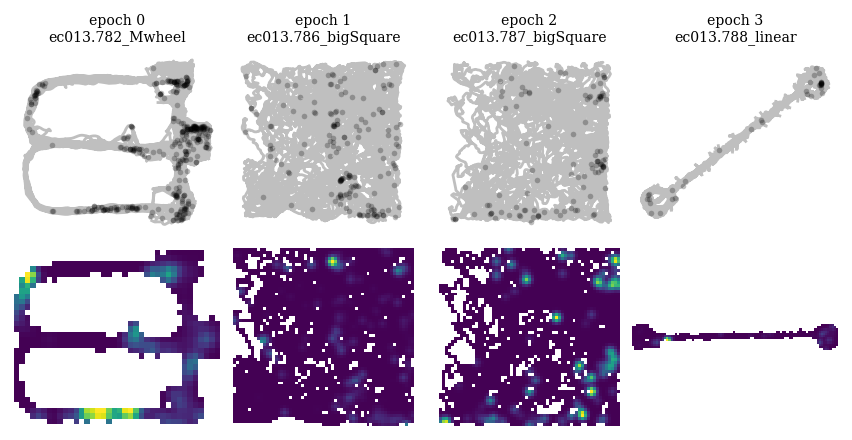

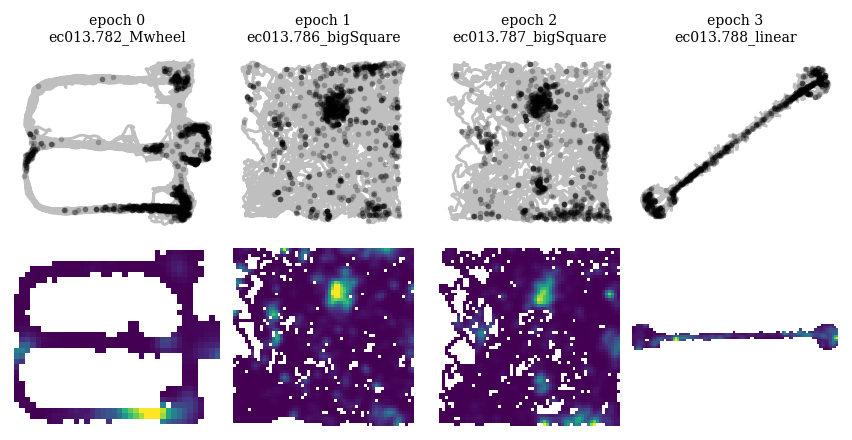

In [50]:
basepath = "Z:\Data\Kenji\ec013.779_791"
UID = 40.0
plot_place_cells(basepath, UID, save_path)

place_save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels\place_cell_examples"
)
save_file = os.path.join(
    place_save_path, basepath.replace(os.sep, "_").replace(":", "_") + str(UID) + ".svg"
)
plt.savefig(save_file, dpi=300, bbox_inches="tight")

UID = 43.0
plot_place_cells(basepath, UID, save_path)
save_file = os.path.join(
    place_save_path, basepath.replace(os.sep, "_").replace(":", "_") + str(UID) + ".svg"
)
plt.savefig(save_file, dpi=300, bbox_inches="tight")


fields in all
field in some


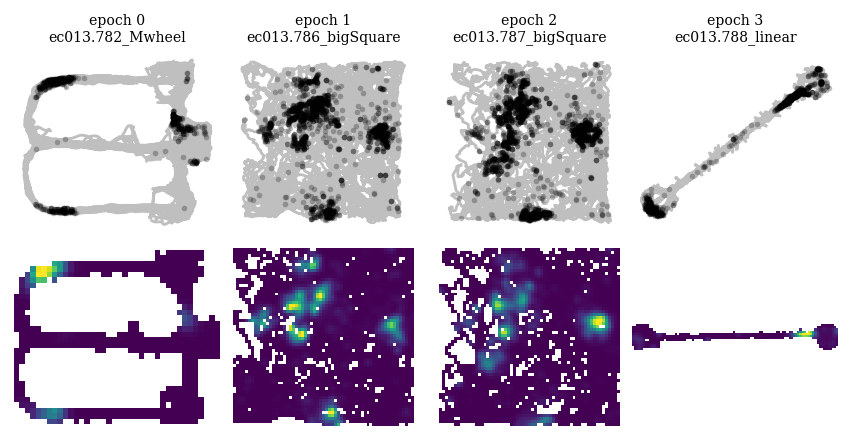

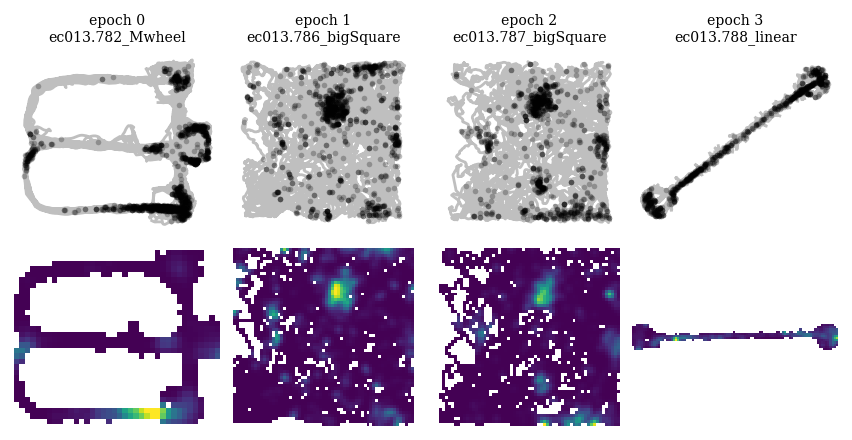

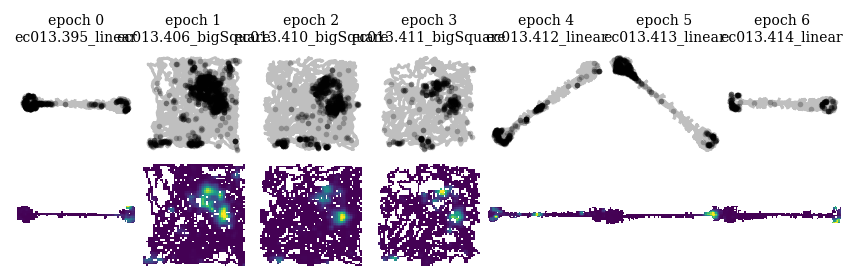

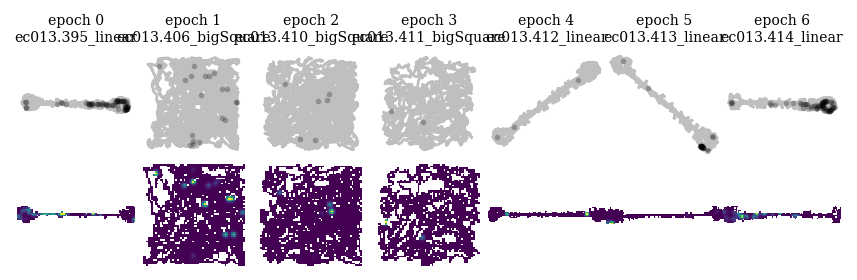

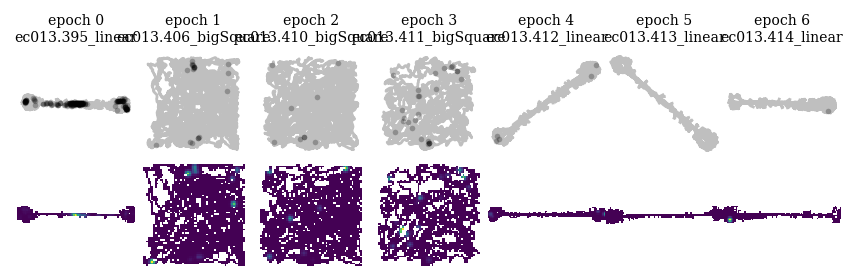

In [43]:
# potential examples

print("fields in all")
basepath = "Z:\\Data\\Kenji\\ec013.779_791"
UID = 52.0
plot_place_cells(basepath, UID, save_path)

basepath = "Z:\\Data\\Kenji\\ec013.779_791"
UID = 43.0
plot_place_cells(basepath, UID, save_path)

basepath = "Z:\\Data\\Kenji\\ec013.393_418"
UID = 88.0
plot_place_cells(basepath, UID, save_path)

print("field in some")
basepath = "Z:\\Data\\Kenji\\ec013.393_418"
UID = 70.0
plot_place_cells(basepath, UID, save_path)

basepath = "Z:\\Data\\Kenji\\ec013.393_418"
UID = 81.0
plot_place_cells(basepath, UID, save_path)


## Testing below

In [88]:
np.sum(sig_pc[0] & sig_pc[1])
sig_pc[0]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False, False, False,  True, False,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
        True])

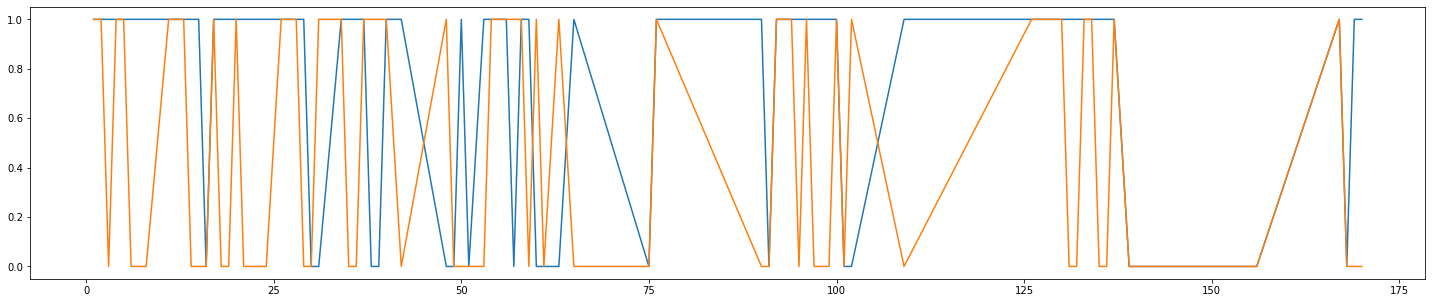

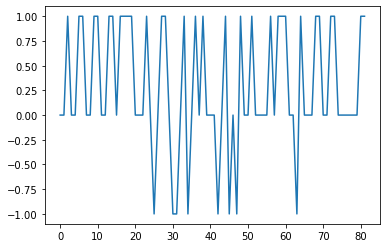

In [90]:
plt.figure(figsize=(25, 5))
plt.plot(np.array(UID[0]), np.array(sig_pc[0]))
plt.plot(np.array(UID[1]), np.array(sig_pc[1]))
plt.show()

plt.plot(np.array(sig_pc[0]) * 1 - np.array(sig_pc[1]) * 1)

# np.all(np.array(UID[0])-np.array(UID[1]))


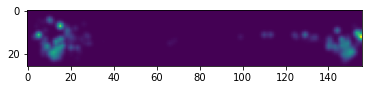

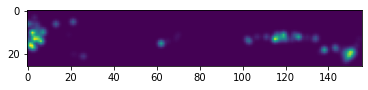

In [9]:
plt.imshow(results["ratemaps"][0])
plt.show()
plt.imshow(results["ratemaps"][10])
# plt.colorbar()
# results['ratemaps']


In [3]:
epoch_df = loading.load_epoch(basepath)
# epoch_df = functions.compress_repeated_epochs(epoch_df)
epoch_df = epoch_df[
    (epoch_df.environment != "sleep") & (epoch_df.environment != "wheel")
]

epoch_df = epoch_df[(epoch_df.stopTime - epoch_df.startTime) / 60 > 5]

for i, ep in enumerate(epoch_df.itertuples()):
    if ep.environment == "linear":
        x = beh_df[beh_df["time"].between(ep.startTime, ep.stopTime)].x
        y = beh_df[beh_df["time"].between(ep.startTime, ep.stopTime)].y

        x, y = functions.linearize_position(x, y)
        beh_df.loc[beh_df["time"].between(ep.startTime, ep.stopTime), "x"] = x
        beh_df.loc[beh_df["time"].between(ep.startTime, ep.stopTime), "y"] = y

display(epoch_df)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

for ep in beh_epochs:
    print(ep.duration)

pos = nel.AnalogSignalArray(
    data=np.array([beh_df.x, beh_df.y]),
    timestamps=beh_df.time,
    fs=1 / statistics.mode(np.diff(beh_df.time)),
)


,name,startTime,stopTime,environment,behavioralParadigm
3,ec013.454_linear,2756.8552,3758.3272,linear,10
7,ec013.459_bigSquare,8065.2710,9146.6150,bigSquare,10
8,ec013.460_bigSquare,9146.6150,11318.7240,bigSquare,10
9,ec013.462_bigSquare,11318.7240,12316.8240,bigSquare,10
10,ec013.463_bigSquare,12316.8240,14083.3240,bigSquare,10
12,ec013.465_linear,14320.3240,15257.7240,linear,10
13,ec013.466_linear,15257.7240,16306.3000,linear,10
14,ec013.469_linear,16306.3000,17113.2120,linear,10


16:41:472 minutes
18:01:344 minutes
36:12:109 minutes
16:38:100 minutes
29:26:500 minutes
15:37:400 minutes
17:28:576 minutes
13:26:912 minutes


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1796b153ca0: 2 signals> for a total of 5:00:59.11040000000000001 hours

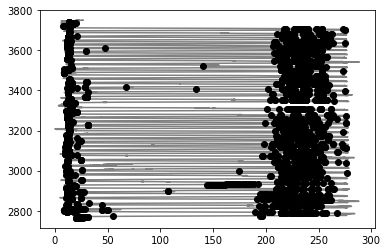

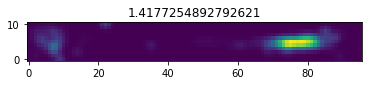

In [9]:
from scipy.ndimage import gaussian_filter
from scipy.ndimage import rotate


def get_ratemap(ts, x, y, st, bin_width=3, smooth_sigma=1):

    fs = 1 / statistics.mode(np.diff(ts))

    x_edges = np.arange(np.nanmin(x), np.nanmax(x), bin_width)
    y_edges = np.arange(np.nanmin(y), np.nanmax(y), bin_width)

    occ, _, _ = np.histogram2d(x, y, bins=(x_edges, y_edges))
    occ = occ / fs

    spk_mat, _, _ = np.histogram2d(
        np.interp(st, ts, x), np.interp(st, ts, y), bins=(x_edges, y_edges)
    )

    ratemap = spk_mat / occ
    ratemap[np.isnan(ratemap)] = 0
    ratemap[np.isinf(ratemap)] = 0

    ratemap = gaussian_filter(ratemap, sigma=smooth_sigma)

    ratemap = rotate(ratemap, angle=-90)
    occ = rotate(occ, angle=-90)

    ratemap = np.fliplr(ratemap)
    occ = np.fliplr(occ)

    return ratemap, occ


speed = nel.utils.ddt_asa(pos[beh_epochs[0]], smooth=True, sigma=0.1, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
st_run = st_unit[beh_epochs[0]][run_epochs]
pos_run = pos[beh_epochs[0]][run_epochs]

ts = pos_run.abscissa_vals
x = pos_run.data[0, :]
y = pos_run.data[1, :]

cell_id = 1
# for cell_id in range(len(st_unit.data)):
plt.plot(x, ts, color="grey", zorder=-1000)
# plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
plt.scatter(np.interp(st_run.data[cell_id], ts, x), st_run.data[cell_id], color="k")

# plt.axis('equal')
plt.show()

ratemap, occupancy = get_ratemap(ts, x, y, st_run.data[cell_id])

plt.imshow(ratemap, origin="lower", interpolation="nearest")
plt.title(functions.spatial_information(ratemap, occupancy))
plt.show()


In [18]:
import warnings

warnings.filterwarnings("ignore")


def surrogate_test_spatial_info(ts, x, y, s, n_shuff=1000):
    def shuff_coords(x, y, n_shuff):
        range_ = len(x)

        surrogate = np.random.choice(
            np.arange(-range_, range_), size=n_shuff, replace=False
        )
        x_temp = []
        y_temp = []
        for n in surrogate:
            x_temp.append(np.roll(x, n))
            y_temp.append(np.roll(y, n))
        return x_temp, y_temp

    def pvalue(shuff_dist, score):
        # DOI: 10.2202/1544-6115.1585
        return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) / (len(shuff_dist) + 1)

    ratemap, occupancy = get_ratemap(ts, x, y, s)
    obs_ic = functions.spatial_information(ratemap, occupancy)

    x_temp, y_temp = shuff_coords(x, y, n_shuff)

    null_ic = []

    for new_xy in zip(x_temp, y_temp):
        ratemap, occupancy = get_ratemap(ts, new_xy[0], new_xy[1], s)
        null_ic.append(functions.spatial_information(ratemap, occupancy))

    return pvalue(null_ic, obs_ic), null_ic, obs_ic


ep = 1
cell_id = 2
speed = nel.utils.ddt_asa(pos[beh_epochs[ep]], smooth=True, sigma=0.1, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
st_run = st_unit[beh_epochs[ep]][run_epochs]
pos_run = pos[beh_epochs[ep]][run_epochs]

ts = pos_run.abscissa_vals
x = pos_run.data[0, :]
y = pos_run.data[1, :]

pval, null, obs = surrogate_test_spatial_info(
    ts, x, y, st_run.data[cell_id], n_shuff=1000
)


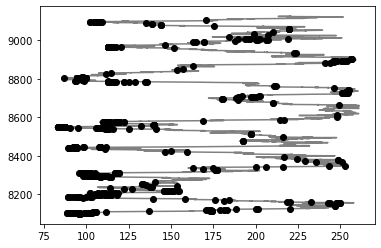

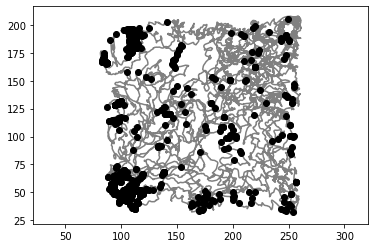

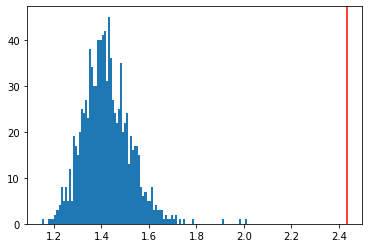

0.000999000999000999


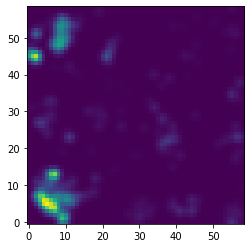

In [19]:
plt.plot(x, ts, color="grey", zorder=-1000)
plt.scatter(np.interp(st_run.data[cell_id], ts, x), st_run.data[cell_id], color="k")

plt.figure()
plt.plot(x, y, color="grey", zorder=-1000)
plt.scatter(
    np.interp(st_run.data[cell_id], ts, x),
    np.interp(st_run.data[cell_id], ts, y),
    color="k",
)
plt.axis("equal")

plt.figure()
plt.hist(null, 100)
plt.axvline(obs, color="r")
plt.show()
print(pval)

plt.figure()
ratemap, occupancy = get_ratemap(ts, x, y, st_run.data[cell_id])
plt.imshow(ratemap, origin="lower", interpolation="nearest")


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


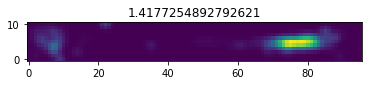

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


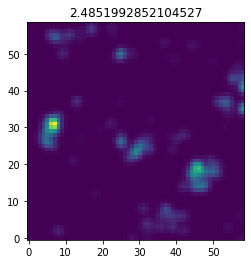

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


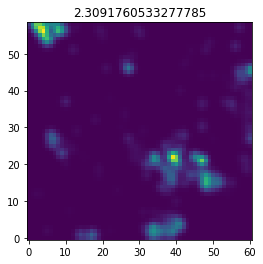

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


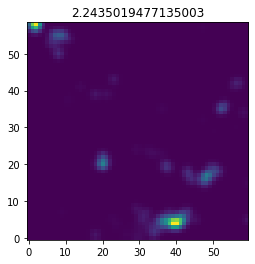

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


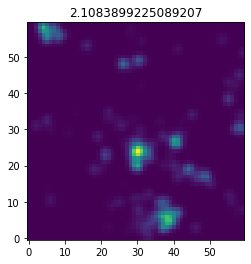

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


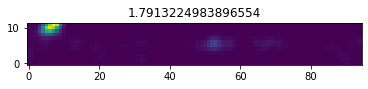

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


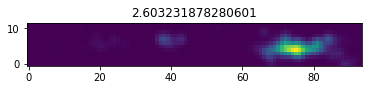

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\AppData\Local\Temp/ipykernel_35132/719187688.py:16: RuntimeWarning: invalid value encountered in true_divide
d:\github\ripple_heterogeneity\python\functions.py:500: RuntimeWarning: invalid value encountered in log2


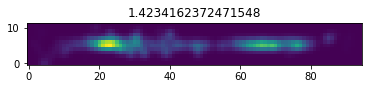

In [191]:
for ep in range(beh_epochs.n_intervals):
    speed = nel.utils.ddt_asa(pos[beh_epochs[ep]], smooth=True, sigma=0.1, norm=True)
    run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4)
    st_run = st_unit[beh_epochs[ep]][run_epochs]
    pos_run = pos[beh_epochs[ep]][run_epochs]

    ts = pos_run.abscissa_vals
    x = pos_run.data[0, :]
    y = pos_run.data[1, :]

    cell_id = 1
    # for cell_id in range(len(st_unit.data)):
    plt.figure()
    # plt.plot(x,y,color='grey',zorder=-1000)
    # plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
    # # plt.scatter(np.interp(st_run.data[cell_id],ts,x),st_run.data[cell_id],color='k')

    # plt.axis('equal')

    ratemap, occupancy = get_ratemap(ts, x, y, st_run.data[cell_id])

    plt.imshow(ratemap, origin="lower", interpolation="nearest")
    plt.title(functions.spatial_information(ratemap, occupancy))
    plt.show()
